# Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab # importo la función para mostrar el gráfico de scipy
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts # Entre otras tools incluye el Dickey-Fuller test
from statsmodels.tsa.seasonal import seasonal_decompose

# Carga y exploración de datos

In [2]:
df = pd.read_csv("Index2018.csv")
df_copy = df.copy() # Creo una copia como buena práctica para contar con el DF completo
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [3]:
df.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


Si el Count da igual en todas las columnas, no hay missing values y las series son comparables

In [4]:
# Chequear missing values
df.isna().sum()
# df.spx.isna().sum() para una variable en particular

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

# Exploración gráfica

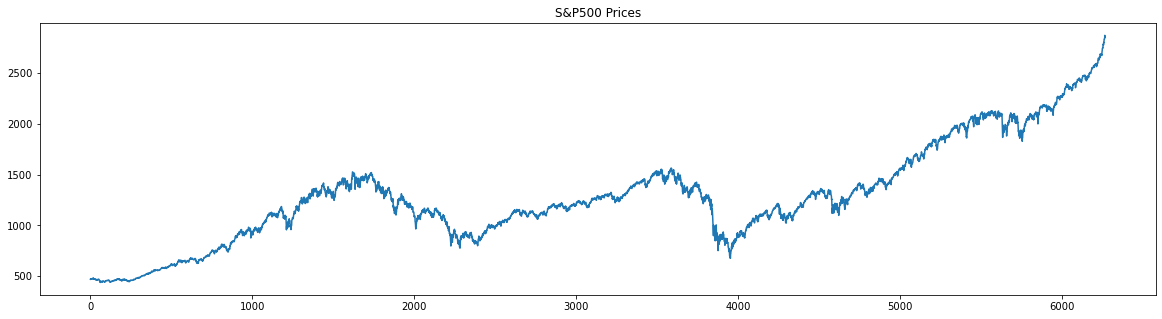

In [5]:
# S&P500 Prices
df.spx.plot(figsize=(20,5),title="S&P500 Prices");

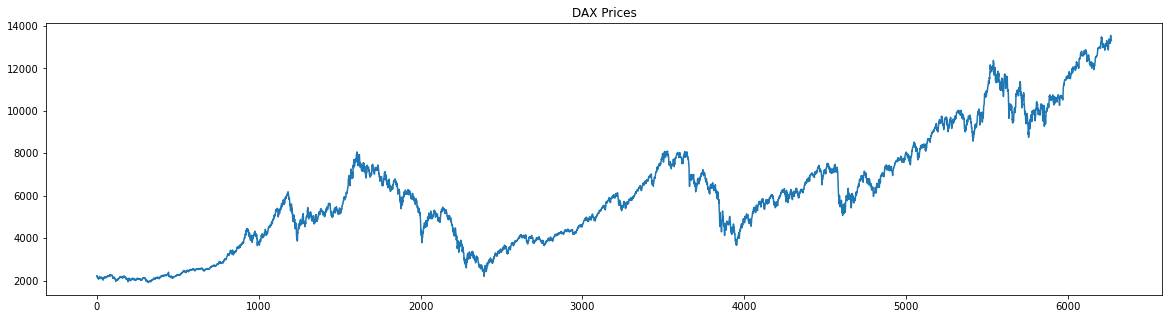

In [6]:
# DAX Prices
df.dax.plot(figsize=(20,5),title="DAX Prices");

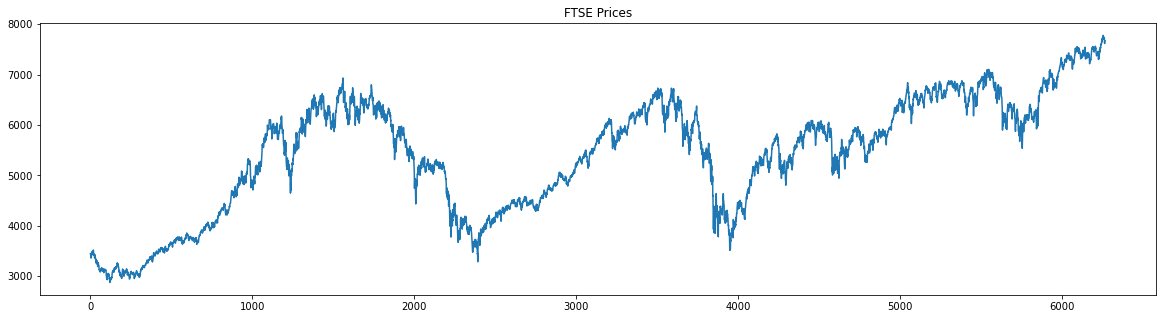

In [7]:
# Footsie Prices
df.ftse.plot(figsize=(20,5),title="FTSE Prices");

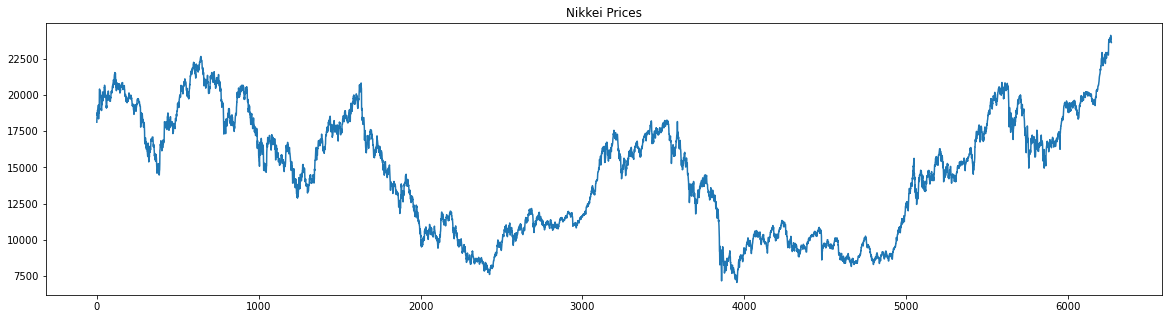

In [8]:
# Nikkei Prices
df.nikkei.plot(figsize=(20,5),title="Nikkei Prices");

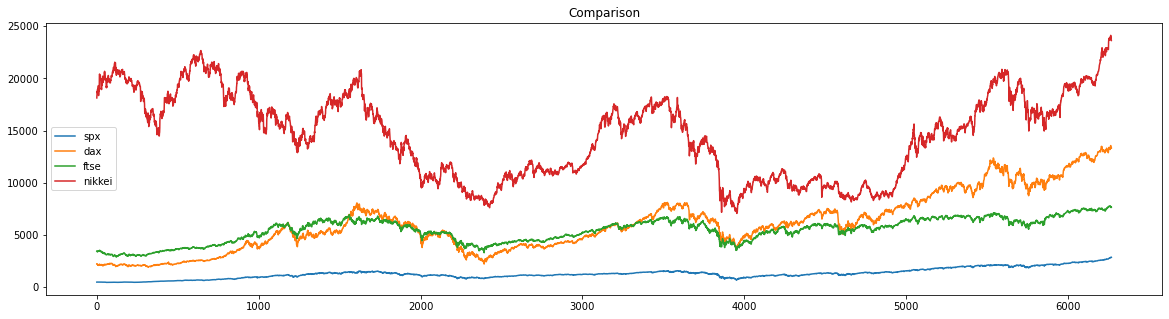

In [9]:
# Plot de todas las series juntas. Tener en cuenta al hacer esto la diferencia de magnitudes/rangos de los valores
df.spx.plot(figsize=(20,5))
df.dax.plot(figsize=(20,5))
df.ftse.plot(figsize=(20,5))
df.nikkei.plot(figsize=(20,5))
plt.legend()
plt.title("Comparison");

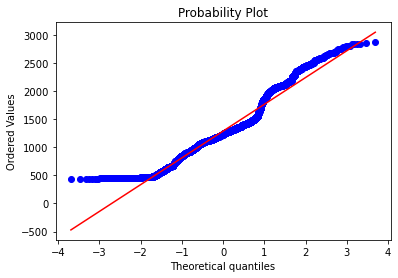

In [10]:
# QQ Plot
scipy.stats.probplot(df.spx, plot=pylab) # el primer argumento es la serie, el segundo el tipo de plot
pylab.show()

En el valor de 500 la serie se aleja de una distribución normal

# Preprocesamiento

In [11]:
# Transformación de la variable "date" a datetime, asignando el cambio en el DF
df.date = pd.to_datetime(df.date, dayfirst=True) # con este argumento queda en formato YYYY/MM/DD

In [12]:
# Chequeo las estadísticas descriptivas
df.date.describe()

C:\Users\j_hor\AppData\Local\Temp\ipykernel_19020\1668544922.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.date.describe()


count                    6269
unique                   6269
top       1994-01-07 00:00:00
freq                        1
first     1994-01-07 00:00:00
last      2018-01-29 00:00:00
Name: date, dtype: object

In [13]:
# Seteo como índice la variable date. Automáticamente, convierto el resto de variables en series de tiempo
df.set_index("date", inplace=True)
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [14]:
# Seteo la frecuencia de tiempo del DF a business days
df = df.asfreq("b")
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


"b" - BUSINESS DAYS (excluye weekends). Importante para evitar generar NAs
"h" - hourly
"d" - daily
"w" - weekly
"m" - monthly 
"a" - annualy

In [15]:
# Chequeo nuevamente si hay NAs
df.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [16]:
# Algunos métodos de imputación. Acá falta un mejor análisis de distribución de las series y los métodos vinculados a
# modelos de ML como el KNN
# Frontfill
df.spx = df.spx.fillna(method="ffill")
# Backfill
df.ftse = df.ftse.fillna(method="bfill")
# Media
df.dax = df.dax.fillna(value=df.dax.mean())
df.nikkei = df.nikkei.fillna(value=df.nikkei.mean())
# Chequeo NAs
df.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [17]:
# Elimino las series con las que no voy a trabajar
del df["ftse"], df["dax"], df["nikkei"]
df.head()

,spx
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


# Split en train/test set

In [18]:
# Defino el size o "cutoff point" del training set (multiplico el length del df por 0.8 para quedarme con el 80% como train set)
size = int(len(df)*0.8)
size

5021

In [19]:
# Defino el training set y el test set
df_train = df.iloc[:size] # train: desde el principio de la serie hasta el punto de corte definido en la variable size
df_test = df.iloc[size:] # test: desde el cutoff point hasta el final

# Readecuación del DF

In [20]:
# Importo la librería de Yahoo Finance
import yfinance
# Configuración de warnings
import warnings
warnings.filterwarnings("ignore")

In [21]:
# Scrap de la data de Yahoo Finance
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", # Los tickers de las series de tiempo (S&P, FTSE, NIKKEI and DAX)
                              start = "1994-01-07",
                              end = "2019-09-27",
                              interval = "1d", # La distancia en tiempo entre dos observaciones
                              group_by = 'ticker', # La forma en que se va a agrupar la data scrapeada
                              auto_adjust = True, # Ajusta automáticamente a los precios de cierre para cada periodo
                              treads = True) # Utilizar o no threads para la descarga masiva 

[*********************100%***********************]  4 of 4 completed


In [22]:
# Creo una copia de backup
raw_data_copy = raw_data.copy()

In [23]:
# Añado las columnas de "close" al dataset 
raw_data['spx'] = raw_data['^GSPC'].Close
raw_data['dax'] = raw_data['^GDAXI'].Close
raw_data['ftse'] = raw_data['^FTSE'].Close
raw_data['nikkei'] = raw_data['^N225'].Close

In [24]:
raw_data = raw_data.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del raw_data['^N225']  # Elimino los tickers originales del dataset
del raw_data['^GSPC']
del raw_data['^GDAXI']
del raw_data['^FTSE']
raw_data=raw_data.asfreq('b') # Seteo de la frecuencia de la data en business days
raw_data=raw_data.fillna(method='ffill') # Imputación de missing values

In [25]:
raw_data.head()

,spx,dax,ftse,nikkei
,,,,
Date,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219


# White Noise

In [26]:
# Creo un array con distribución normal a partir de la serie de "spx"
# El argumento "loc" toma números del promedio de la distribución de la serie "spx" (en este caso)
# El argumento "scale" indica el ancho de la distribución de la serie "spx" (en este caso toma la std del "spx")
# El argumento "size" es igual al largo del DF para hacer comparables las series
white_noise = np.random.normal(loc=df.spx.mean(), scale=df.spx.std(), size=len(df))

In [27]:
# Agrego como columna del DF la serie de white noise
df['white noise'] = white_noise
df.describe()

,spx,white noise
count,6277.000000,6277.000000
mean,1288.642547,1279.780886
std,487.868210,486.909491
min,438.920000,-392.394049
25%,992.715221,960.645817
50%,1233.761241,1279.537518
75%,1460.250000,1597.869594
max,2872.867839,3299.842223


Los valores son similares porque la serie de white noise está generada a partir del promedio y desviación estándar del spx

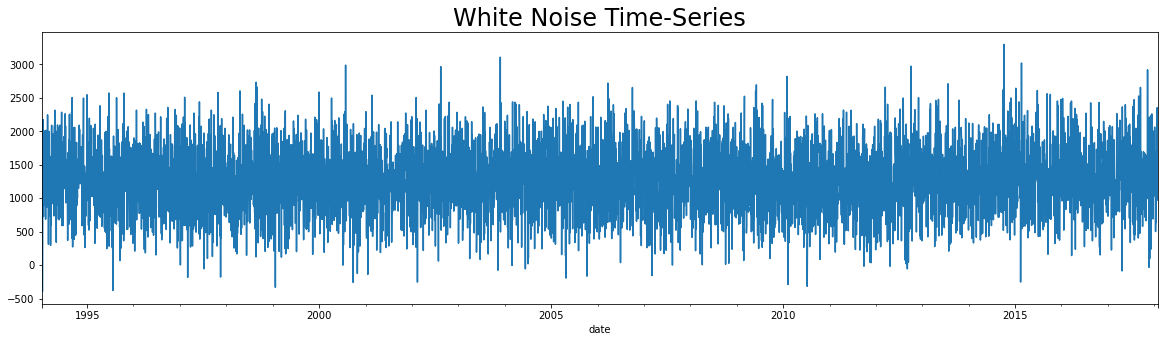

In [28]:
# Ploteo la serie de white noise. Se aprecia que los valores se ubican próximos a la media
df["white noise"].plot(figsize = (20,5))
plt.title("White Noise Time-Series", size= 24)
plt.show()

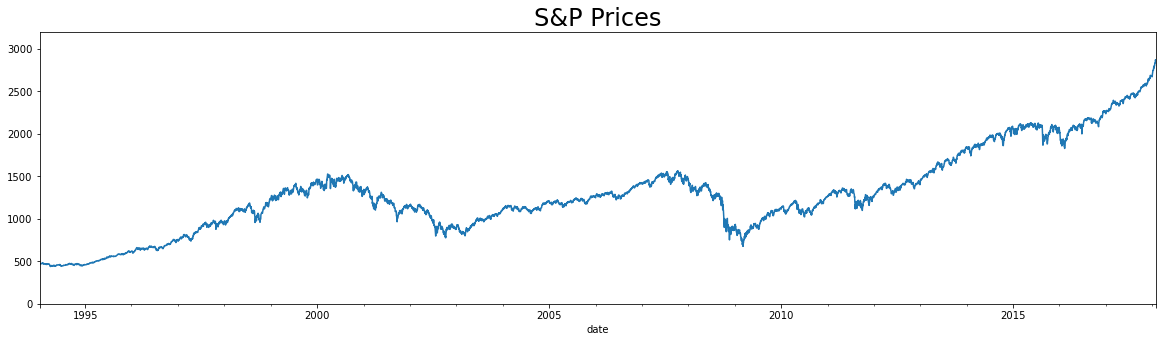

In [29]:
# Comparación con la serie de spx
df.spx.plot(figsize=(20,5))
plt.title("S&P Prices", size = 24)
plt.ylim(0,3200) # Ajusta la escala del eje Y
plt.show()

# Random Walk

In [30]:
random_walk = pd.read_csv("RandWalk.csv")
random_walk.date = pd.to_datetime(random_walk.date, dayfirst = True) # Transformo en datetime la columna de date
random_walk.set_index("date", inplace = True) # Seteo como index la columna "date"
random_walk = random_walk.asfreq('b') # Seteo en business days la frecuencia de la serie

In [31]:
random_walk.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [32]:
# Agrego la serie de random walk al DF
df['random walk'] = random_walk.price
df.head()

,spx,white noise,random walk
date,,,
1994-01-07,469.90,1515.895578,1122.139662
1994-01-10,475.27,1239.376372,1080.347860
1994-01-11,474.13,1081.902178,1082.095245
1994-01-12,474.17,1384.136648,1083.639265
1994-01-13,472.47,-392.394049,1067.146255


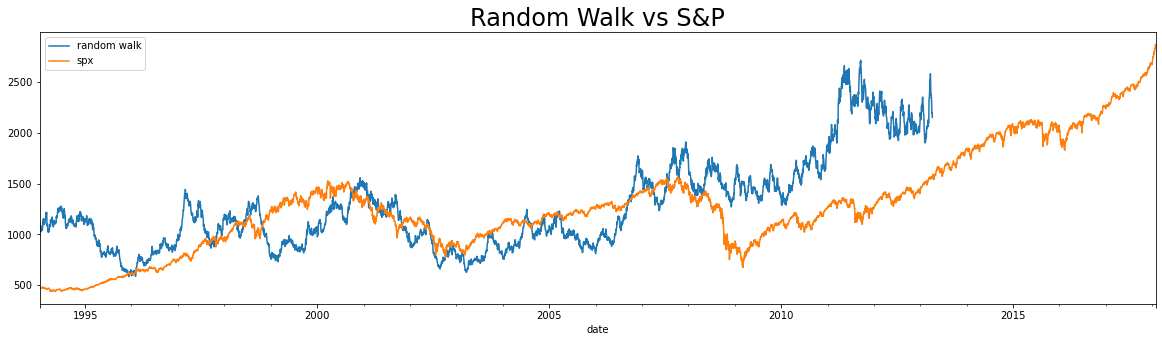

In [33]:
df["random walk"].plot(figsize = (20,5))
df["spx"].plot()
plt.title("Random Walk vs S&P", size = 24)
plt.legend()
plt.show()

# Estacionariedad

In [34]:
# Correr el Dickey-Fuller test para una serie de tiempo
sts.adfuller(df.spx)

(1.1194986381728427,
 0.9953796476080692,
 10,
 6266,
 {'1%': -3.4313940441948807,
  '5%': -2.8620013751563964,
  '10%': -2.567015587023998},
 50258.209867750025)

* HIPÓTESIS NULA: LA SERIE NO ES ESTACIONARIA
* HIPÓTESIS ALTERNATIVA: LA SERIE ES ESTACIONARIA

* 1- Estadístico de test, el cual se compara contra el valor crítico
* 2- P-value del estadístico de test
* 3- Número de lags utilizados en la regresión para obtener el estadístico de test. Habría autocorrelación corriendo atrás 10 lags/periodos
* 4- Número de observaciones utilizadas en el análisis. Depende del número de lags utilizado en la regresión
* 5- 1%, 5% y 10% de valores críticos. Se usan como niveles de significancia
* 6- Criterio de información maximizada. Más chico el valor, más fácil hacer predicción a futuro

El P-value sugiere que hay un 99% de probabilidad de no rechazar la hipótesis nula. PARA RECHAZAR LA HIPÓTESIS NULA Y ASUMIR QUE LA SERIE ES ESTACIONARIA DEBO TENER UN P-VALUE DE 0.04 O MENOR (asumiendo un nivel de significancia del 5%).

El estadístico de test es mayor a los valores críticos de 1%, 5% y 10%. Esto indica que no se encuentra suficiente evidencia de estacionariedad en la serie

In [35]:
# Correr el Dickey-Fuller test para el white noise
sts.adfuller(df["white noise"])

(-80.59696946782394,
 0.0,
 0,
 6276,
 {'1%': -3.4313923799633836,
  '5%': -2.862000639842268,
  '10%': -2.567015195598801},
 94961.50466789275)

El white noise es un proceso estacionario, por ello:

el P-value es 0

No tiene autocorrelación (por eso hay 0 lags involucrados)

# Estacionalidad

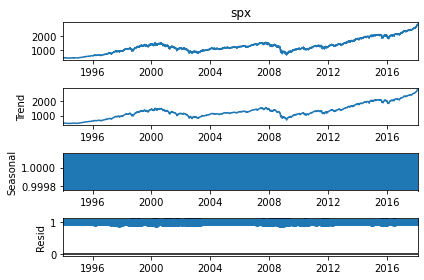

In [36]:
# Decomposición estacional con enfoque multiplicativo 
seasonal_decomposition_m = seasonal_decompose(df.spx, model = "multiplicative")
seasonal_decomposition_m.plot()
plt.show()

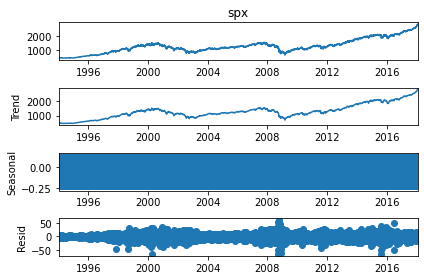

In [37]:
# Decomposición estacional con enfoque aditivo
seasonal_decomposition_m = seasonal_decompose(df.spx, model = "additive")
seasonal_decomposition_m.plot()
plt.show()

La trend/tendencia es casi igual a la serie observada porque la función de decomposición utiliza los valores de los periodos previos para establecerla

Los valores del "seasonal" son un rectángulo, oscilan en ese rango (-0.25 a 0) y el tamaño de la figura es pequeño. Es decir, no hay un patrón cíclico

Los residuos/errores tienen mayores variaciones en el 2008 y 2016. Desde un análisis de negocio, es la inestabilidad durante ciertos eventos del mercado (como la burbuja de 2008)

En general, no se aprecia estacionalidad en esta serie de tiempo

# ACF (Autocorrelation Function)

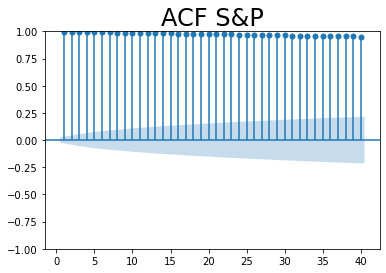

In [38]:
# Puedo definir los lags/periodos previos que necesite (40 es un valor estándar en el análisis). 
sgt.plot_acf(df.spx, lags = 40, zero = False) # El argumento "zero" indica si incluir o no el current period en el gráfico
plt.title("ACF S&P", size = 24)
plt.show()

Los valores del Eje X representan los lags.
Los valores del Eje Y representan los valores posibles para el coeficiente de autocorrelación (entre -1 y 1).

Las líneas representan la autocorrelación entre la serie de tiempo y una secuencia de lags de ella misma. Por ejemplo, la primer línea indica la autocorrelación para 1 periodo de tiempo atrás, la segunda línea para 2 periodos de tiempo atrás, y así sucesivamente.

El área azul representa la significancia estadística: los valores situados fuera son significativamente diferentes a 0, lo cual sugiere la existencia de autocorrelación para un lag específico. Esta área se va expandiendo ya que a medida que crece la distancia en el tiempo es más improbable que la autocorrelación persista (o sea, que los valores se parezcan).

En este caso, se puede concluir que hay dependencia de tiempo en la serie porque los coeficientes son significativos (y se puede predecir con 40 lags).

# PACF (Partial Autocorrelation Function)

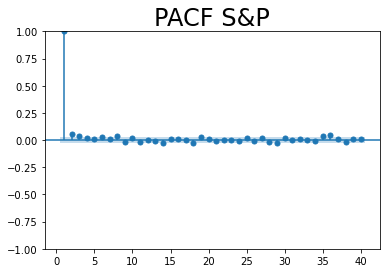

In [39]:
sgt.plot_pacf(df.spx, lags = 40, zero = False, method = ('ols')) # método para computarlo (ver librería)
plt.title("PACF S&P", size = 24)
plt.show()

Sólo los primeros lags son significativamente distintos a 0. Esto es así porque el PACF cancela todos los efectos indirectos en que un valor pasado afecta a un valor presente

El primer valor es igual al ACF porque no hay canales intermedios en que el valor pasado afecta al valor presente

Otra cosa a mirar es si son coeficientes positivos o negativos.

El modelo va a incluir menos de 25 lags porque de allí hacia atrás los lags no tienen significancia estadística. Estos valores, al estar tan lejos del valor presente, lo afectan negativamente.

# Autoregressive Model (AR)

Importo el modelo ARIMA ya que ARMA fue reemplazado por el primero en el upgrade de Statsmodels

En el argumento order van así: AR (p), I (d), MA (q)

## AR(1) model

In [40]:
# Importo el modelo
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2

# Instanciación del modelo
model_ar = ARIMA(raw_data.ftse, order=(1, 0, 0)) # Esto define un simple AR1 model

# El primer número del argumento "order" representa la cantidad de valores pasados/lags a incorporar en el modelo
# El tercer número del argumento "order" representa los valores de residuo (al poner 0, no se tienen en cuenta)

In [41]:
# Entrenamiento del modelo. El modelo va a encontrar la Constante y los coeficientes más apropiados
results_ar = model_ar.fit()

In [42]:
# Sumario de entrenamiento del modelo
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6710
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -36792.976
Date:                Sun, 02 Oct 2022   AIC                          73591.953
Time:                        17:41:52   BIC                          73612.387
Sample:                    01-10-1994   HQIC                         73599.009
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5545.2013    544.183     10.190      0.000    4478.622    6611.781
ar.L1          0.9990      0.001   1549.175      0.000       0.998       1.000
sigma2      3387.2818     35.241     96.117      0.000    3318.210    3456.354
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):              3631.34
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.95   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

const = constante de la regresión

ar.L1.ftse = coeficiente Phi de 1 lag (por eso L1)

* La columna "coef" contiene el valor de los coeficientes estimados
* La columna "std err" es una medida de cuan alejadas están, en promedio, las predicciones de los valores reales
* La columna "z" contiene el test estadístico asociado para la significancia del p-value (en este caso que dan 0 se puede concluir que ambos coeficientes son significativamente diferentes a 0)
* Las últimas 2 columnas son el intervalo de confianza del 95 % (importante que no incluya el 0 al ser una regresión)

LOS MODELOS AUTORREGRESIVOS SIRVEN PARA MODELAR SERIES DE TIEMPO ESTACIONARIAS/QUE TIENEN UNA TREND. PARA SERIES DE TIEMPO NO ESTACIONARIAS NO PERFORMAN BIEN.

## AR(2) model

In [43]:
# Instanciación del modelo
model_ar2 = ARIMA(raw_data.ftse, order=(2,0,0)) # Modifico el argumento "order", incluyendo 2 lags en el modelo
# Entrenamiento del modelo
results_ar2 = model_ar2.fit()
# Sumario de entrenamiento del modelo
results_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6710
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -36792.815
Date:                Sun, 02 Oct 2022   AIC                          73593.630
Time:                        17:41:53   BIC                          73620.875
Sample:                    01-10-1994   HQIC                         73603.038
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5545.2033    460.695     12.037      0.000    4642.259    6448.148
ar.L1          0.9895      0.009    115.931      0.000       0.973       1.006
ar.L2          0.0093      0.009      1.090      0.276      -0.007       0.026
sigma2      3386.5531     35.326     95.866      0.000    3317.316    3455.790
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3614.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.96   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El coeficiente del segundo lag no es significativamente distinto a 0 (ver P-value e intervalo de confianza que incluye el 0).
Eso significa que los precios de 2 días atrás no afectan significativamente al precio del presente. Podría decirse que los efectos de los valores pasados los captura el lag de 1 día atrás

## AR(3) model

In [44]:
# Instanciación del modelo con 3 lags
model_ar3 = ARIMA(raw_data.ftse, order=(3,0,0))
# Entrenamiento del modelo
results_ar3 = model_ar3.fit()
# Sumario de entrenamiento del modelo
results_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6710
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -36786.480
Date:                Sun, 02 Oct 2022   AIC                          73582.961
Time:                        17:41:54   BIC                          73617.018
Sample:                    01-10-1994   HQIC                         73594.721
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5545.2033    471.761     11.754      0.000    4620.569    6469.838
ar.L1          0.9891      0.009    115.300      0.000       0.972       1.006
ar.L2         -0.0338      0.012     -2.875      0.004      -0.057      -0.011
ar.L3          0.0435      0.008      5.360      0.000       0.028       0.059
sigma2      3380.3508     35.299     95.764      0.000    3311.167    3449.535
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3625.66
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.23
Prob(H) (two-sided):                  0.86   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## AR(4) model

In [45]:
# Instanciación del modelo con 3 lags
model_ar4 = ARIMA(raw_data.ftse, order=(4,0,0))
# Entrenamiento del modelo
results_ar4 = model_ar4.fit()
# Sumario de entrenamiento del modelo
results_ar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6710
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -36778.642
Date:                Sun, 02 Oct 2022   AIC                          73569.284
Time:                        17:41:55   BIC                          73610.152
Sample:                    01-10-1994   HQIC                         73583.397
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5545.2033    486.397     11.401      0.000    4591.882    6498.525
ar.L1          0.9870      0.009    114.399      0.000       0.970       1.004
ar.L2         -0.0322      0.012     -2.721      0.007      -0.055      -0.009
ar.L3         -0.0043      0.011     -0.388      0.698      -0.026       0.018
ar.L4          0.0484      0.008      6.061      0.000       0.033       0.064
sigma2      3372.9096     35.940     93.849      0.000    3302.469    3443.350
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3453.38
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.27
Prob(H) (two-sided):                  0.71   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A medida que incluimos más lags al modelo, el Log Likelihood fue incrementándose, lo cual es bueno ya que implica un modelo con mejor poder predictivo.

El criterio de información (AIC/BIC) fue disminuyendo, lo cual también es bueno ya que implica un modelo que requiere menor cantidad de data para realizar predicciones precisas.

## Log Likelihood Ratio Test (LLR Test)

In [46]:
# Utilizamos este test para comparar modelos y determinar cuál tiene mejor poder predictivo
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf # Entreno el modelo 1 y guardo el resultado en la variable L1. ".llf" es el atributo
    L2 = mod_2.fit().llf # Entreno el modelo 2 y guardo el resultado en la variable L2. ".llf" es el atributo
    LR = (2*(L2-L1)) # Computo el estadístico de test y guardo el resultado en la variable LR.
    p = chi2.sf(LR, DF).round(3) # Al test chi2 le paso el estadístico de test (1er argumento) y los grados de libertad (2do argumento)
    return p # "p" es el p-value 

mod_1 y mod_2 son los modelos a comparar

DF son los grados de libertad

In [47]:
# Comparo el log likelihood ratio del modelo 2 con el del modelo 3
LLR_test(model_ar2, model_ar3)

0.0

Con el p-value resultante puede decirse que la diferencia en el log likelihood ratio entre el modelo de 2 lags y el modelo de 3 lags es significativa, lo cual lleva a elegir un modelo más complejo (es decir, el modelo con 3 lags). Esto es así aún cuando el modelo incluya algunos coeficientes que no sean significativamente distintos a 0.

El LLR test se debe repetir hasta que:

* 1- No se alcance una diferencia significativa del log likelihood ratio comparando 2 modelos;
* 2- Los coeficientes de los mayores lags no tengan un p-value significativo.

Cuando se cumplen estas 2 condiciones, se entiende que seguir incluyendo lags no mejora las predicciones del modelo.

Para determinar la factibilidad de un modelo AR debemos primero saber si la serie es estacionaria/no estacionaria corriendo el Dickey-Fuller test.

In [48]:
sts.adfuller(raw_data.ftse)

(-1.8110164492201046,
 0.37500621136295653,
 6,
 6703,
 {'1%': -3.431325951964754,
  '5%': -2.8619712893553078,
  '10%': -2.56699957169418},
 73179.06310965391)

El P-value del test, asumiendo un nivel de significancia del 5%, indica que no podemos concluir que la data tiene un proceso estacionario; es decir, asumimos que tiene un proceso NO-estacionario.

Por lo tanto, no va a servir un modelo Autorregresivo para realizar predicciones precisas.

En estos casos hay que transformar la serie de tiempo en estacionaria: para ello, en finanzas se utilizan los retornos en lugar de los precios (es decir, la variación porcentual)

## Returns (transformación a serie estacionaria)

In [49]:
# Utilizamos el método .pct_change() para estimar la variación porcentual entre periodos
raw_data["returns"] = raw_data.ftse.pct_change(1).mul(100) 

# El "1" representa la distancia en periodos de tiempo que queremos comparar. Es el valor por default
# .mul(100) lo multiplica por ese factor para expresarlo en porcentaje

La serie de "returns" va a tener un elemento menos que la de precios porque para el primer periodo no hay returns (no tiene preiodo previo contra el cual comparar).

In [50]:
# Eliminamos del raw_data el primer elemento para evitar inconvenientes en el cálculo de correlaciones de los returns
raw_data = raw_data.iloc[1:]

In [51]:
# Corremos el Dickey-Fuller test para los returns
sts.adfuller(raw_data.returns)

(-15.560216855227909,
 2.047041711885152e-28,
 34,
 6674,
 {'1%': -3.431330194323744,
  '5%': -2.8619731638149655,
  '10%': -2.5670005695065963},
 20113.798889198504)

El estadístico de test cae más a la izquierda (es menor) que el valor crítico del 1%, con lo cual se puede asumir que la data tiene un proceso estacionario.

### ACF y PACF de los returns

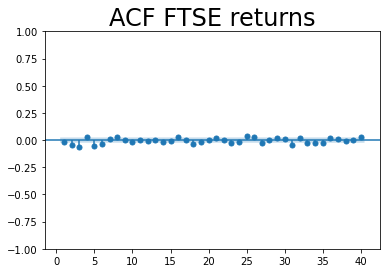

In [52]:
# ACF de los returns
sgt.plot_acf(raw_data.returns, lags = 40, zero = False)
plt.title("ACF FTSE returns", size = 24)
plt.show()

Los primeros lags tienen coeficientes significativos y a excepción del cuarto, signo negativo (indicaría un ajuste de mercado)

Los valores de la trend se mueven en distintas direcciones, lo que sugiere que los retornos de la semana entera son relevantes para los periodos de la misma

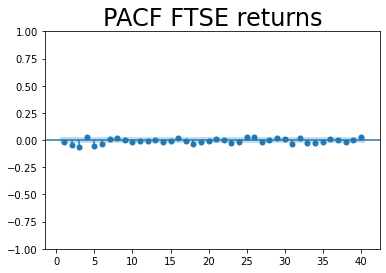

In [53]:
# PACF de los returns
sgt.plot_pacf(raw_data.returns, lags = 40, zero = False, method= ("ols"))
plt.title("PACF FTSE returns", size = 24)
plt.show()

El gráfico de PACF se asemeja al de ACF, con lo cual se puede interpretar que los precios presentes suelen moverse en la dirección opuesta a los precios pasados (propio de una tendencia cíclica)

### AR(1) model for returns

In [54]:
# Instanciación del modelo
model_returns_ar1 = ARIMA(raw_data.returns, order=(1,0,0))
# Entrenamiento del modelo
results_returns_ar1 = model_returns_ar1.fit()
# Sumario de entrenamiento del modelo
results_returns_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6709
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -10143.702
Date:                Sun, 02 Oct 2022   AIC                          20293.405
Time:                        17:41:59   BIC                          20313.838
Sample:                    01-11-1994   HQIC                         20300.461
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0173      0.013      1.300      0.194      -0.009       0.043
ar.L1         -0.0178      0.007     -2.463      0.014      -0.032      -0.004
sigma2         1.2044      0.010    117.811      0.000       1.184       1.224
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11550.64
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Higher AR(n) models

In [55]:
# AR(6)
# Instanciación del modelo
model_returns_ar6 = ARIMA(raw_data.returns, order=(6,0,0))
# Entrenamiento del modelo
results_returns_ar6 = model_returns_ar6.fit()
# Sumario de entrenamiento del modelo
results_returns_ar6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6709
Model:                 ARIMA(6, 0, 0)   Log Likelihood              -10104.600
Date:                Sun, 02 Oct 2022   AIC                          20225.201
Time:                        17:42:02   BIC                          20279.691
Sample:                    01-11-1994   HQIC                         20244.017
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.012      1.479      0.139      -0.006       0.040
ar.L1         -0.0203      0.008     -2.606      0.009      -0.036      -0.005
ar.L2         -0.0490      0.007     -7.170      0.000      -0.062      -0.036
ar.L3         -0.0687      0.007    -10.085      0.000      -0.082      -0.055
ar.L4          0.0252      0.007      3.585      0.000       0.011       0.039
ar.L5         -0.0572      0.007     -8.389      0.000      -0.071      -0.044
ar.L6         -0.0368      0.008     -4.875      0.000      -0.052      -0.022
sigma2         1.1905      0.011    109.348      0.000       1.169       1.212
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9814.95
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
# AR(7)
# Instanciación del modelo
model_returns_ar7 = ARIMA(raw_data.returns, order=(7,0,0))
# Entrenamiento del modelo
results_returns_ar7 = model_returns_ar7.fit()
# Sumario de entrenamiento del modelo
results_returns_ar7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6709
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -10104.310
Date:                Sun, 02 Oct 2022   AIC                          20226.620
Time:                        17:42:05   BIC                          20287.921
Sample:                    01-11-1994   HQIC                         20247.788
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.012      1.459      0.144      -0.006       0.041
ar.L1         -0.0199      0.008     -2.557      0.011      -0.035      -0.005
ar.L2         -0.0485      0.007     -7.042      0.000      -0.062      -0.035
ar.L3         -0.0689      0.007     -9.988      0.000      -0.082      -0.055
ar.L4          0.0258      0.007      3.638      0.000       0.012       0.040
ar.L5         -0.0568      0.007     -8.289      0.000      -0.070      -0.043
ar.L6         -0.0366      0.008     -4.838      0.000      -0.051      -0.022
ar.L7          0.0093      0.008      1.215      0.225      -0.006       0.024
sigma2         1.1904      0.011    108.681      0.000       1.169       1.212
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9774.89
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
LLR_test(model_returns_ar6, model_returns_ar7)

0.446

En el modelo de 7 lags fallan:

El P-value del séptimo lag es superior al nivel de significancia del 0.05. 
El LLR_test (comparando con el modelo de 6 lags)
El AIC/BIC es mayor al modelo de 6 lags
El log likelihood es el mismo

Por eso se escoge el modelo AR de 6 lags.

## Normalización de series de tiempo

### Normalización de la serie de precios

In [58]:
# Asigno el primer periodo de la serie a una variable
benchmark = raw_data.ftse.iloc[0]
# Divido todos los valores de la serie por el periodo inicial y los multiplico por 100 para expresar la variación en %
raw_data["normalization"] = raw_data.ftse.div(benchmark).mul(100)

In [59]:
# Corro el Dickey-Fuller test para chequear la estacionariedad de la data normalizada
sts.adfuller(raw_data.normalization)

(-1.7973089727207505,
 0.38179853007534853,
 6,
 6702,
 {'1%': -3.4313260976415894,
  '5%': -2.861971353721746,
  '10%': -2.566999605957717},
 26050.982931170518)

El P-value alto sugiere que no hay estacionariedad

### Normalización de la serie de returns

In [60]:
# Normalizar los returns permite una comparación relativa del profitability de las series
benchmark_returns = raw_data.returns.iloc[0] # guardo como benchmark el primer periodo de la serie
# Creo la serie normalizada
raw_data["normalized_returns"] = raw_data.returns.div(benchmark_returns).mul(100) 
# Chequeamos si la nueva serie tiene estacionariedad (debería tenerla, al derivar de una serie que es estacionaria)
sts.adfuller(raw_data.normalized_returns)

(-15.560216855227743,
 2.047041711886121e-28,
 34,
 6674,
 {'1%': -3.431330194323744,
  '5%': -2.8619731638149655,
  '10%': -2.5670005695065963},
 84908.59515967015)

El estadístico de test (bastante menor que el 1% de significancia) sugiere que la serie tiene estacionariedad.

Como regla general, la normalización de una serie de tiempo no afecta su estacionariedad.

## Selección de modelos AR para serie normalizada (returns)

Utilizar valores normalizados no tiene impacto en la selección del modelo (no varían los coeficientes)

## Residuos de modelos AR

### Serie de precios de FTSE

In [61]:
# El método .resid me devuelve los residuos del resultado de un modelo
raw_data['residual_price'] = results_ar4.resid

In [62]:
# Calculo el promedio y la varianza de los residuos
print("Promedio de los Residuos:",raw_data.residual_price.mean())
print("Varianza de los Residuos:",raw_data.residual_price.var())

Promedio de los Residuos: 0.6424126780390046
Varianza de los Residuos: 3371.9579727816495


El promedio es cercano a 0, pero la varianza es muy alta. Esto se debe a que los modelos AR no performan bien para data no estacionaria.

In [63]:
sts.adfuller(raw_data.residual_price)

# La data es estacionaria

(-35.401283526388404,
 0.0,
 5,
 6703,
 {'1%': -3.431325951964754,
  '5%': -2.8619712893553078,
  '10%': -2.56699957169418},
 73166.8868116806)

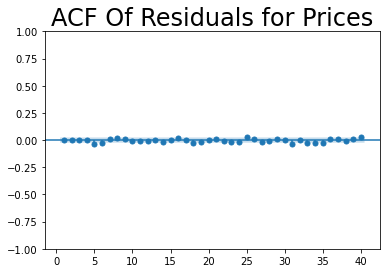

In [64]:
# Chequeo que los residuos sean random data/white noise para no dejar trend fuera del modelo
sgt.plot_acf(raw_data.residual_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices", size=24)
plt.show()

La mayoría de los coeficientes no son significativamente distintos a 0, lo cual sugiere random data/white noise

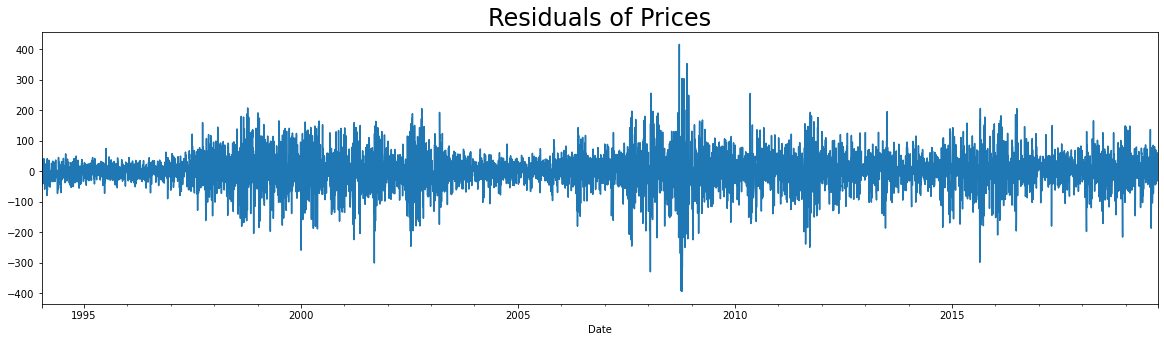

In [65]:
raw_data.residual_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()

Con este gráfico se puede concluir que los residuos no siguen un patrón en la serie de precios de FTSE.

Si los residuos no serían random data/white noise, hay un patrón que hay que modelar.

### Serie de returns de FTSE

In [66]:
# Creo la serie de residuos de los returns del FTSE
raw_data['residual_returns'] = results_returns_ar6.resid

In [67]:
# Calculo el promedio y la varianza de los residuos
print("Promedio de los Residuos:",raw_data.residual_returns.mean())
print("Varianza de los Residuos:",raw_data.residual_returns.var())

# Promedio cercano a 0 y varianza cercana a 1 indican que es un buen modelo

Promedio de los Residuos: -3.731504226231257e-05
Varianza de los Residuos: 1.1906770279271652


In [68]:
sts.adfuller(raw_data.residual_returns)

(-15.414559807574053,
 3.091642853341884e-28,
 34,
 6674,
 {'1%': -3.431330194323744,
  '5%': -2.8619731638149655,
  '10%': -2.5670005695065963},
 20115.175504403007)

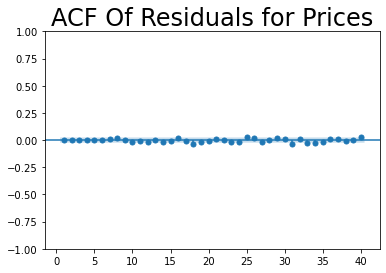

In [69]:
# Chequeo que los residuos sean "random"
sgt.plot_acf(raw_data.residual_returns, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices", size=24)
plt.show()

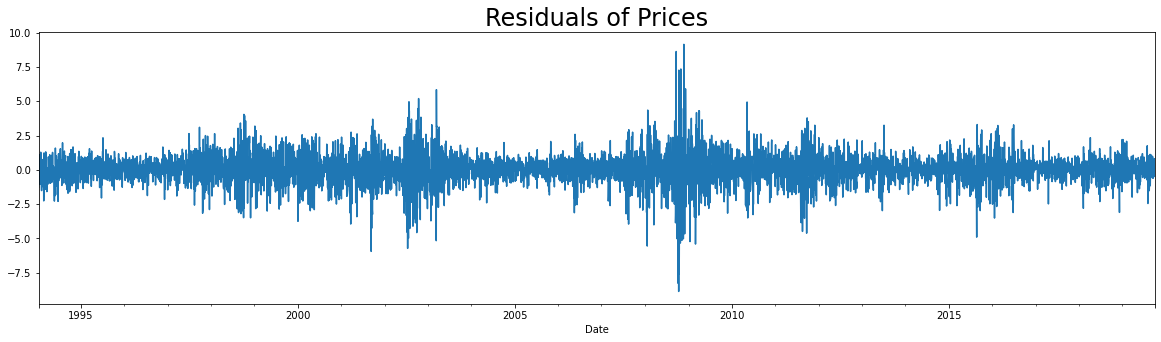

In [70]:
raw_data.residual_returns[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()

# Moving Average Models

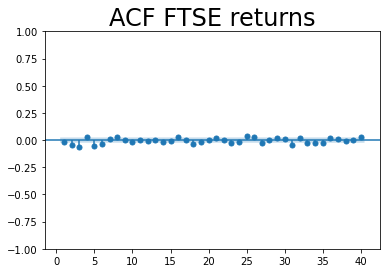

In [71]:
# ACF de los returns de FTSE. El ACF se usa en estos modelos para determinar la cantidad de lags a incluir (se observa que
# hasta 8 lags los coeficientes tienen significancia)
sgt.plot_acf(raw_data.returns, lags = 40, zero = False)
plt.title("ACF FTSE returns", size = 24)
plt.show()

## MA(1) model

In [72]:
# Instanciación del modelo. Filtro desde el segundo valor de la serie para no tener missing values
model_returns_ma1 = ARIMA(raw_data.returns[1:], order=(0,0,1)) # En este caso, incorporo el residuo de 1 lag
results_returns_ma1 = model_returns_ma1.fit()
results_returns_ma1.summary()

# order = (p, i, q)
# p = Autorregresive components (cantidad de valores de los lags)
# q = Moving Average components (cantidad de residuos)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -10142.299
Date:                Sun, 02 Oct 2022   AIC                          20290.598
Time:                        17:42:14   BIC                          20311.031
Sample:                    01-12-1994   HQIC                         20297.654
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0175      0.013      1.311      0.190      -0.009       0.044
ma.L1         -0.0198      0.007     -2.746      0.006      -0.034      -0.006
sigma2         1.2045      0.010    117.719      0.000       1.184       1.225
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             11528.66
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El primer lag tiene significancia (corroborarlo con el ACF).

Se espera que los efectos compuestos, con el transcurso del tiempo, reduzcan su influencia en el periodo presente, lo cual hace que sea factible establecer un límite de lags a incluir en el modelo.

## Higher-lag MA models for Returns

In [73]:
# Instanciación del modelo
model_returns_ma2 = ARIMA(raw_data.returns[1:], order=(0,0,2)) # En este caso, incorporo el residuo de 2 lags (seguir probando)
results_returns_ma2 = model_returns_ma2.fit()
print(results_returns_ma2.summary())
print("*****************")
print("LLR Test P-value:", LLR_test(model_returns_ma1, model_returns_ma2))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -10134.630
Date:                Sun, 02 Oct 2022   AIC                          20277.261
Time:                        17:42:16   BIC                          20304.505
Sample:                    01-12-1994   HQIC                         20286.669
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0175      0.013      1.369      0.171      -0.008       0.042
ma.L1         -0.0251      0.007     -3.424      0.001      -0.039      -0.011
ma.L2         -0.0470      0.007     -7.030      0.0

El modelo con 2 lags de residuos tiene P-values significativos en ambos lags, un log likelihood ratio mayor y AIC/BIC menor, con lo cual es mejor que el primer modelo. El P-value significativo del LLR Test lo confirma.

In [74]:
# Instanciación de un MA model con 6 lags
model_returns_ma6 = ARIMA(raw_data.returns[1:], order=(0,0,6)) # En este caso, incorporo el residuo de 6 lags (seguir probando)
results_returns_ma6 = model_returns_ma6.fit()
print(results_returns_ma6.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(0, 0, 6)   Log Likelihood              -10104.989
Date:                Sun, 02 Oct 2022   AIC                          20225.979
Time:                        17:42:21   BIC                          20280.467
Sample:                    01-12-1994   HQIC                         20244.795
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.012      1.484      0.138      -0.006       0.040
ma.L1         -0.0197      0.008     -2.538      0.011      -0.035      -0.004
ma.L2         -0.0464      0.007     -6.727      0.0

In [75]:
# Instanciación de un MA model con 7 lags
model_returns_ma7 = ARIMA(raw_data.returns[1:], order=(0,0,7)) # En este caso, incorporo el residuo de 7 lags
results_returns_ma7 = model_returns_ma7.fit()
print(results_returns_ma7.summary())
print("*****************")
print("LLR Test P-value:", LLR_test(model_returns_ma6, model_returns_ma7))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(0, 0, 7)   Log Likelihood              -10104.666
Date:                Sun, 02 Oct 2022   AIC                          20227.332
Time:                        17:42:25   BIC                          20288.631
Sample:                    01-12-1994   HQIC                         20248.500
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0175      0.012      1.465      0.143      -0.006       0.041
ma.L1         -0.0205      0.008     -2.629      0.009      -0.036      -0.005
ma.L2         -0.0468      0.007     -6.776      0.0

El modelo MA con 7 lags falla en el P-value del coeficiente del 7mo lag, así como en el P-value del LLR Test. Sin embargo, el ACF mostraba que el 8vo lag tenía un coeficiente significativo, con lo cual probamos dicho modelo.

In [76]:
# Instanciación de un MA model con 8 lags
model_returns_ma8 = ARIMA(raw_data.returns[1:], order=(0,0,8)) # En este caso, incorporo el residuo de 7 lags
results_returns_ma8 = model_returns_ma8.fit()
print(results_returns_ma8.summary())
print("*****************")
print("LLR Test P-value:", LLR_test(model_returns_ma7, model_returns_ma8, DF= 2)) # con 2 grados de libertad

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -10102.222
Date:                Sun, 02 Oct 2022   AIC                          20224.444
Time:                        17:42:35   BIC                          20292.555
Sample:                    01-12-1994   HQIC                         20247.964
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0175      0.012      1.422      0.155      -0.007       0.042
ma.L1         -0.0202      0.008     -2.559      0.010      -0.036      -0.005
ma.L2         -0.0469      0.007     -6.754      0.0

Efectivamente, el P-value del coeficiente del 8vo lag es significativo para el modelo, así como el P-value del LLR Test devuelve lo mismo, con lo cual preferimos este último modelo. El ACF luego muestra una consecución de coeficientes no relevantes, como regla general es importante verlo para decidir el punto de corte de lags a incluir en el modelo. 

## Residuos de modelos MA

In [77]:
# Creo la columna con los residuos del MA(8) model
raw_data["residuals_returns_ma8"] = results_returns_ma8.resid[1:]
# Calculo el promedio y la varianza de dichos residuos
print("Promedio de los residuos del MA8 model:", round(raw_data.residuals_returns_ma8.mean(),3))
print("Varianza de los residuos del MA8 model:", round(raw_data.residuals_returns_ma8.var(),3))
print("Desviación Estándar de los residuos del MA8 model:", round(raw_data.residuals_returns_ma8.std(),3))

Promedio de los residuos del MA8 model: 0.0
Varianza de los residuos del MA8 model: 1.19
Desviación Estándar de los residuos del MA8 model: 1.091


In [78]:
# Usamos la regla 68 (1 std del promedio) - 95 (2 std) - 99.7 (3 std) para saber el accuracy hipotético de nuestras 
# predicciones. En este caso, sería 3.27 hacia cada lado del promedio
3 * raw_data.residuals_returns_ma8.std()

3.273047000225726

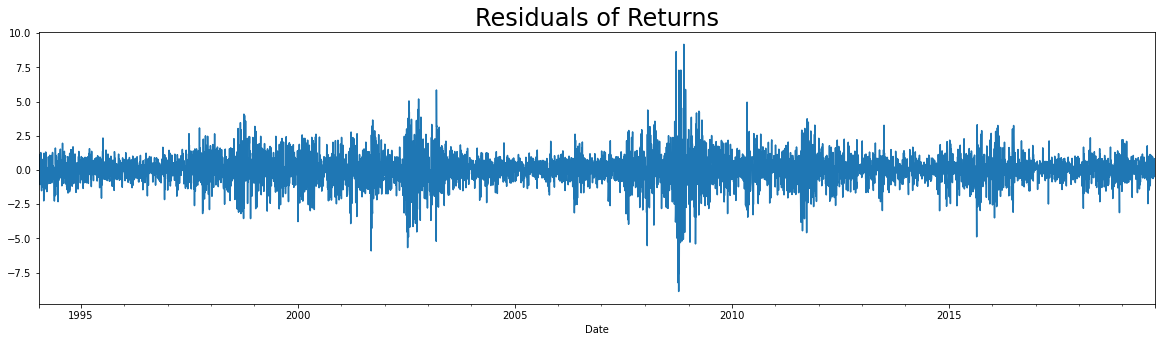

In [79]:
# Plot de los residuos para chequear que sean random data
raw_data.residuals_returns_ma8[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [80]:
# Corremos el Dickey-Fuller test para chequear la estacionariedad de los residuos. No-estacionariedad implicaría que la
# data no es White Noise/Random Data
sts.adfuller(raw_data.residuals_returns_ma8[2:])

(-81.88796668482831,
 0.0,
 0,
 6706,
 {'1%': -3.4313255151950286,
  '5%': -2.8619710963711977,
  '10%': -2.5669994689648994},
 20108.89166305221)

El P-value es 0, con lo cual el test confirma que la data es estacionaria

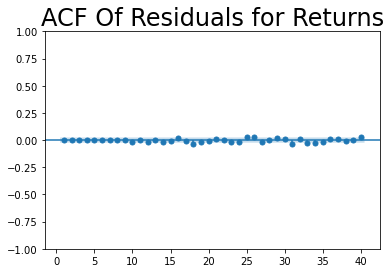

In [81]:
# ACF plot para chequear que los coeficientes no sean significativos/distintos a 0 (lo que sucede cuando es White Noise)
sgt.plot_acf(raw_data.residuals_returns_ma8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

La mayoría de los coeficientes no son significativamente distintos a 0. Si miramos los primeros 17 lags, podemos interpretar que nuestro modelo ya está incorporándolos. Ello es un indicador de performance del modelo.

Los coeficientes de los lags más alejados en el tiempo pierden relevancia en las predicciones, además que incluirlos aumenta la chance de overfitting del modelo.

## Normalización de retornos en modelos MA

In [82]:
# Instanciación del modelo con la serie normalizada
model_normalized_returns_ma8 = ARIMA(raw_data.normalized_returns[1:], order=(0,0,8))
results_normalized_returns_ma8 = model_normalized_returns_ma8.fit()
results_normalized_returns_ma8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     normalized_returns   No. Observations:                 6708
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -42669.551
Date:                Sun, 02 Oct 2022   AIC                          85359.102
Time:                        17:42:45   BIC                          85427.212
Sample:                    01-12-1994   HQIC                         85382.622
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2419      1.579     -1.420      0.156      -5.337       0.853
ma.L1         -0.0202      0.008     -2.554      0.011      -0.036      -0.005
ma.L2         -0.0469      0.007     -6.741      0.000      -0.060      -0.033
ma.L3         -0.0654      0.007     -9.387      0.000      -0.079      -0.052
ma.L4          0.0302      0.007      4.131      0.000       0.016       0.045
ma.L5         -0.0517      0.007     -7.393      0.000      -0.065      -0.038
ma.L6         -0.0315      0.008     -4.109      0.000      -0.047      -0.016
ma.L7          0.0098      0.008      1.287      0.198      -0.005       0.025
ma.L8          0.0265      0.008      3.334      0.001       0.011       0.042
sigma2      1.965e+04    181.888    108.044      0.000    1.93e+04       2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9753.47
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Utilizar valores normalizados no tiene impacto en la selección de un modelo MA (no varían los coeficientes). Esto también puede comprobarse ploteando el ACF (va a ser idéntico al de la serie no normalizada).

### Chequeo de los residuos del MA model en la serie normalizada

In [83]:
# Creo la variable de residuos normalizados de la serie de retornos, correspondiente al MA8 Model
raw_data['residuals_normalized_returns_ma8'] = results_normalized_returns_ma8.resid[1:]

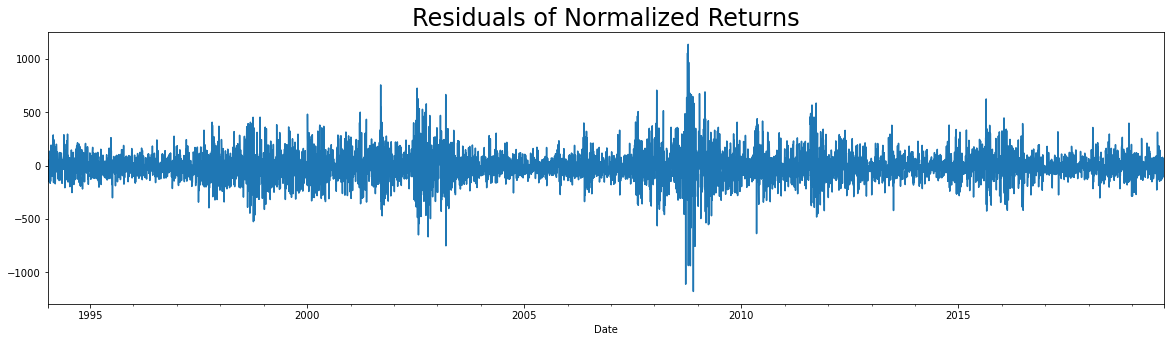

In [84]:
# Ploteo dichos residuos normalizados
raw_data.residuals_normalized_returns_ma8[1:].plot(figsize=(20,5))
plt.title("Residuals of Normalized Returns",size=24)
plt.show()

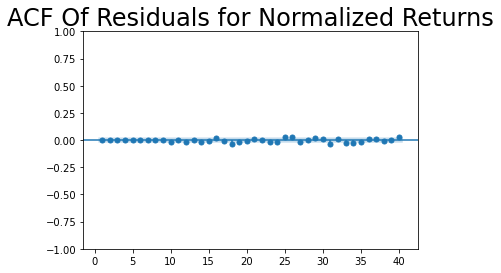

In [85]:
# Plot del ACF
sgt.plot_acf(raw_data.residuals_normalized_returns_ma8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Normalized Returns",size=24)
plt.show()

Gráficamente se aprecia random data y los coeficientes no son significativos, con lo cual el modelo es correcto (no hay ningún patrón/tendencia del que no de cuenta).

## MA models para data no estacionaria

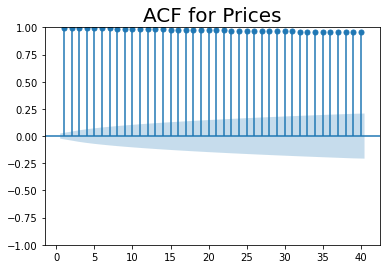

In [86]:
# Utilizo la serie de precios sin normalizar del FTSE
sgt.plot_acf(raw_data.ftse, zero = False, lags = 40)
plt.title("ACF for Prices", size=20)
plt.show()

Al ser todos los coeficientes significativos, ningún Moving Average model puede capturar infinitos lags, con lo cual no sirven para las estimaciones con data No-estacionaria. Que los coeficientes sean próximos a 1 significa que tienen en cuenta todo el error para hacer las predicciones.

Es necesario incluir en estos casos un componente Autorregresivo.

Sin embargo, los MA models son buenos prediciendo random walk ya que tienen en cuenta el error de los periodos previos.

# ARMA Model

## ARMA(1,1)

In [87]:
# Instanciación de un ARMA model con p,q de 1,1
model_returns_ar1_ma1 = ARIMA(raw_data.returns[1:], order=(1,0,1)) # El modelo incorpora 1 periodo previo y 1 error previo
results_returns_ar1_ma1 = model_returns_ar1_ma1.fit()
results_returns_ar1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10127.075
Date:                Sun, 02 Oct 2022   AIC                          20262.150
Time:                        17:42:50   BIC                          20289.394
Sample:                    01-12-1994   HQIC                         20271.558
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.012      1.484      0.138      -0.006       0.040
ar.L1          0.8168      0.034     24.349      0.000       0.751       0.883
ma.L1         -0.8572      0.030    -28.629      0.000      -0.916      -0.799
sigma2         1.1990      0.010    115.738      0.000       1.179       1.219
===================================================================================
Ljung-Box (L1) (Q):                   2.06   Jarque-Bera (JB):             11100.25
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El coeficiente del AR component es positivo: esto significa que la serie se mueve en una trend de valores consecutivos positivos o negativos.

Hay que comparar el ARMA(1,1) con el AR(1) y el MA(1) para saber cual predice mejor. Esto se hace con el LLR test.

In [88]:
# LLR Test
print("\nARMA vs AR ", LLR_test(model_returns_ar1, model_returns_ar1_ma1))
print("\nARMA vs MA ", LLR_test(model_returns_ma1, model_returns_ar1_ma1))


ARMA vs AR  0.0

ARMA vs MA  0.0


El P-value significativo sugiere que utilizar AR y MA en conjunto mejora el accuracy de predicción.

## Higher-Lag ARMA models for returns

Evaluar con el ACF (para el MA) y PACF (para el AR) la significancia de los coeficientes para saber cuántos lags esperar incluir en el modelo.

Al complementarse, el modelo conjunto va a contener menos componentes de cada tipo. Si cada componente individualmente explica con precisión, por ejemplo con 8 y 6 lags, entonces se espera que el modelo conjunto contenga menos componentes.

Ello se puede ver en modelos complejos cuando muchos de los coeficientes no son significativamente distintos a 0.

In [89]:
# Instanciación del modelo con 3 AR y 3 MA
model_returns_ar3_ma3 = ARIMA(raw_data.returns[1:], order=(3,0,3))
results_returns_ar3_ma3 = model_returns_ar3_ma3.fit()
results_returns_ar3_ma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(3, 0, 3)   Log Likelihood              -10110.579
Date:                Sun, 02 Oct 2022   AIC                          20237.157
Time:                        17:43:13   BIC                          20291.646
Sample:                    01-12-1994   HQIC                         20255.973
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.012      1.454      0.146      -0.006       0.041
ar.L1         -0.1311      0.073     -1.793      0.073      -0.274       0.012
ar.L2         -0.1898      0.060     -3.164      0.002      -0.307      -0.072
ar.L3          0.4787      0.062      7.723      0.000       0.357       0.600
ma.L1          0.1160      0.070      1.655      0.098      -0.021       0.253
ma.L2          0.1300      0.059      2.216      0.027       0.015       0.245
ma.L3         -0.5534      0.059     -9.460      0.000      -0.668      -0.439
sigma2         1.1932      0.011    109.230      0.000       1.172       1.215
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             10254.47
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
# Corro el LLR test para evaluar si el modelo generado predice mejor que el ARMA(1,1)
LLR_test(model_returns_ar1_ma1, model_returns_ar3_ma3, DF = 4) # Ajusta los grados de libertad del test
# El test arroja que el modelo más complejo predice mejor

0.0

In [91]:
# Instanciación del modelo con 3 AR y 2 MA
model_returns_ar3_ma2 = ARIMA(raw_data.returns[1:], order=(3,0,2))
results_returns_ar3_ma2 = model_returns_ar3_ma2.fit()
results_returns_ar3_ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -10116.416
Date:                Sun, 02 Oct 2022   AIC                          20246.832
Time:                        17:43:39   BIC                          20294.509
Sample:                    01-12-1994   HQIC                         20263.296
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0175      0.012      1.422      0.155      -0.007       0.042
ar.L1         -0.2520      0.077     -3.254      0.001      -0.404      -0.100
ar.L2          0.2306      0.080      2.890      0.004       0.074       0.387
ar.L3         -0.0776      0.008    -10.223      0.000      -0.093      -0.063
ma.L1          0.2310      0.078      2.968      0.003       0.078       0.384
ma.L2         -0.2808      0.080     -3.529      0.000      -0.437      -0.125
sigma2         1.1953      0.011    109.975      0.000       1.174       1.217
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10031.34
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Todos los coeficientes del modelo son significativamente distintos a 0. Tip: mirar si existe una tendencia de crecimiento/decrecimiento de los coeficientes de cada componente.

*Si el modelo más complejo incluye coeficientes no significativamente distintos a 0, escoger el modelo más simple. Recordar que para la selección del modelo es importante no tener coeficientes cuyo P-value no sea significativamente distinto a 0 (si no la regresión no funciona). Elegir según el log likelihood ratio más alto y el criterio de información más bajo.

*Observar a qué lag corresponde el P-value insignificante

## Análisis de Residuos del ARMA

In [92]:
raw_data['residuals_returns_ar3_ma2'] = results_returns_ar3_ma2.resid[1:]

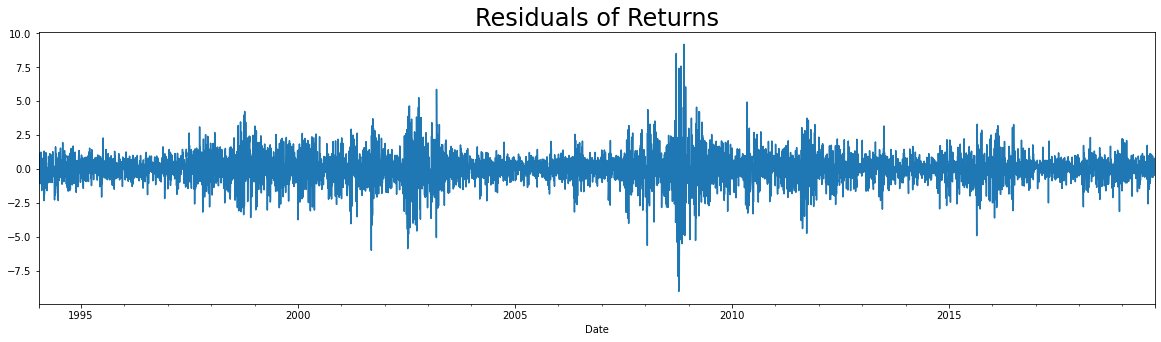

In [93]:
raw_data.residuals_returns_ar3_ma2.plot(figsize = (20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

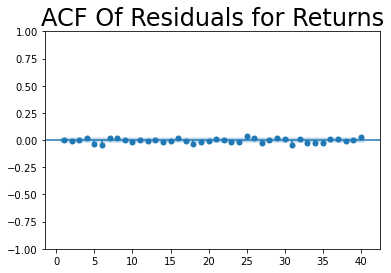

In [94]:
sgt.plot_acf(raw_data.residuals_returns_ar3_ma2[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

Lo que se busca lograr con el análisis de los residuos es que los coeficientes no tengan significancia; es decir, que sean random data y no exista un patrón que quede por modelar.

## ARMA models para precios (data No-estacionaria)

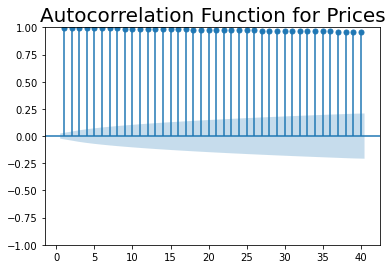

In [95]:
sgt.plot_acf(raw_data.ftse, unbiased=True, zero = False, lags = 40)
plt.title("Autocorrelation Function for Prices",size=20)
plt.show()

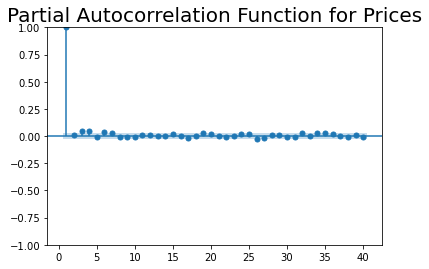

In [96]:
sgt.plot_pacf(raw_data.ftse, lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("Partial Autocorrelation Function for Prices",size=20)
plt.show()

In [97]:
model_ar1_ma1 = ARIMA(raw_data.ftse, order=(1,0,1))
results_ar1_ma1 = model_ar1_ma1.fit()
results_ar1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6709
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -36787.729
Date:                Sun, 02 Oct 2022   AIC                          73583.457
Time:                        17:43:41   BIC                          73610.702
Sample:                    01-11-1994   HQIC                         73592.866
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5545.5170    455.876     12.165      0.000    4652.017    6439.017
ar.L1          0.9988      0.001   1606.278      0.000       0.998       1.000
ma.L1         -0.0098      0.009     -1.149      0.251      -0.027       0.007
sigma2      3387.4947     35.350     95.827      0.000    3318.210    3456.780
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3612.55
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.21
Prob(H) (two-sided):                  0.98   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El P-value del MA indica que el coeficiente no es significativamente distinto a 0, con lo cual el modelo es demasiado simple para captar el patrón de la serie.

In [98]:
# Evaluamos los residuos del modelo
raw_data["residuals_ar1_ma1"] = results_ar1_ma1.resid

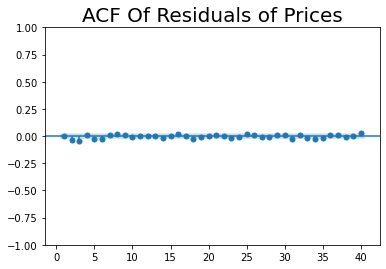

In [99]:
sgt.plot_acf(raw_data.residuals_ar1_ma1, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.show()

Los primeros lags son significativos, con lo cual es bueno probar con un modelo que los incluya.

In [100]:
# Instanciamos un nuevo modelo con los lags a incluir: 6 AR, 6 MA
model_ar6_ma6 = ARIMA(raw_data.ftse, order=(6,0,6))
results_ar6_ma6 = model_ar6_ma6.fit()
results_ar6_ma6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6709
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -36763.724
Date:                Sun, 02 Oct 2022   AIC                          73555.448
Time:                        17:44:08   BIC                          73650.804
Sample:                    01-11-1994   HQIC                         73588.376
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5545.5170    692.881      8.004      0.000    4187.495    6903.539
ar.L1          0.7674      0.213      3.604      0.000       0.350       1.185
ar.L2          0.2828      0.351      0.806      0.420      -0.405       0.971
ar.L3         -0.6064      0.296     -2.049      0.041      -1.187      -0.026
ar.L4          0.3552      0.233      1.522      0.128      -0.102       0.813
ar.L5          0.1286      0.222      0.579      0.563      -0.307       0.564
ar.L6          0.0710      0.136      0.524      0.600      -0.195       0.337
ma.L1          0.2191      0.213      1.029      0.303      -0.198       0.636
ma.L2         -0.0990      0.181     -0.547      0.585      -0.454       0.256
ma.L3          0.4963      0.158      3.138      0.002       0.186       0.806
ma.L4          0.1922      0.137      1.402      0.161      -0.076       0.461
ma.L5          0.0162      0.138      0.117      0.907      -0.254       0.286
ma.L6         -0.0699      0.015     -4.818      0.000      -0.098      -0.041
sigma2      3364.5527     36.725     91.614      0.000    3292.572    3436.533
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3344.51
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.28
Prob(H) (two-sided):                  0.65   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Luego plotear nuevamente el ACF de los residuos de la serie para descartar que quede trend sin modelar

# ARIMA Model

## ARIMA for Prices

In [101]:
model_ar1_i1_ma1 = ARIMA(raw_data.ftse, order=(1,1,1))
results_ar1_i1_ma1 = model_ar1_i1_ma1.fit()
results_ar1_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6709
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -36768.982
Date:                Sun, 02 Oct 2022   AIC                          73543.964
Time:                        17:44:09   BIC                          73564.397
Sample:                    01-11-1994   HQIC                         73551.020
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8316      0.043     19.340      0.000       0.747       0.916
ma.L1         -0.8643      0.039    -22.362      0.000      -0.940      -0.789
sigma2      3377.1988     35.179     96.002      0.000    3308.250    3446.148
===================================================================================
Ljung-Box (L1) (Q):                   2.43   Jarque-Bera (JB):              3702.81
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.32
Prob(H) (two-sided):                  0.93   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA sólo estima los coeficientes de p y q. Integración significa que transforma la data, no hay modelamiento en sí. 

## Residuos de ARIMA(1,1,1)

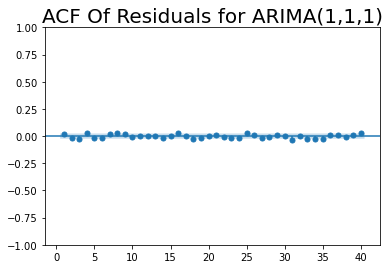

In [102]:
# ACF del ARIMA(1,1,1). Recordar graficar a partir del segundo elemento de la serie.
# El ACF de los residuos sirve para saber si no dejamos ninguna trend sin modelar
raw_data['residuals_ar1_i1_ma1'] = results_ar1_i1_ma1.resid
sgt.plot_acf(raw_data.residuals_ar1_i1_ma1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

Los lags 3 y 4 son significativos, con lo cual incluirlos en el modelo mejorara su performance.

## Higher-Lag ARIMA

In [103]:
# Entrenamiento de modelos con distintos parametros en el argumento order
model_ar1_i1_ma2 = ARIMA(raw_data.ftse, order=(1,1,2))
results_ar1_i1_ma2 = model_ar1_i1_ma2.fit()
model_ar1_i1_ma3 = ARIMA(raw_data.ftse, order=(1,1,3))
results_ar1_i1_ma3 = model_ar1_i1_ma3.fit()
model_ar2_i1_ma1 = ARIMA(raw_data.ftse, order=(2,1,1))
results_ar2_i1_ma1 = model_ar2_i1_ma1.fit()
model_ar3_i1_ma1 = ARIMA(raw_data.ftse, order=(3,1,1))
results_ar3_i1_ma1 = model_ar3_i1_ma1.fit()
model_ar3_i1_ma2 = ARIMA(raw_data.ftse, order=(3,1,2))
results_ar3_i1_ma2 = model_ar3_i1_ma2.fit()

In [104]:
# Print del Log Likelihood y el AIC para comparar modelos
print("ARIMA(1,1,1):  \t LL = ", results_ar1_i1_ma1.llf, "\t AIC = ", results_ar1_i1_ma1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_ar1_i1_ma2.llf, "\t AIC = ", results_ar1_i1_ma2.aic)
print("ARIMA(1,1,3):  \t LL = ", results_ar1_i1_ma3.llf, "\t AIC = ", results_ar1_i1_ma3.aic) # > LL y < AIC
print("ARIMA(2,1,1):  \t LL = ", results_ar2_i1_ma1.llf, "\t AIC = ", results_ar2_i1_ma1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_ar3_i1_ma1.llf, "\t AIC = ", results_ar3_i1_ma1.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar3_i1_ma2.llf, "\t AIC = ", results_ar3_i1_ma2.aic)

ARIMA(1,1,1):  	 LL =  -36768.98212219069 	 AIC =  73543.96424438138
ARIMA(1,1,2):  	 LL =  -36765.45995647197 	 AIC =  73538.91991294394
ARIMA(1,1,3):  	 LL =  -36763.705527098406 	 AIC =  73537.41105419681
ARIMA(2,1,1):  	 LL =  -36765.340487738926 	 AIC =  73538.68097547785
ARIMA(3,1,1):  	 LL =  -36765.072655871845 	 AIC =  73540.14531174369
ARIMA(3,1,2):  	 LL =  -36763.250789097045 	 AIC =  73538.50157819409


In [105]:
# Comparamos ARIMA(1,1,2) con ARIMA(1,1,3)
(LLR_test(model_ar1_i1_ma2, model_ar1_i1_ma3))

0.061

In [106]:
# Comparamos ARIMA(1,1,1) con ARIMA(1,1,3)
(LLR_test(model_ar1_i1_ma1, model_ar1_i1_ma3))

0.001

El LLR Test confirma que le modelo mas complejo performara mejor.

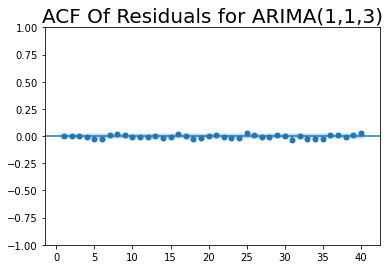

In [107]:
# Graficamos los residuos para saber si el modelo deja fuera alguna trend
raw_data['residuals_ar1_i1_ma3'] = results_ar1_i1_ma3.resid
sgt.plot_acf(raw_data.residuals_ar1_i1_ma3[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,3)", size=20)
plt.show()

Hay lags (por ejemplo el 6to) que continuan teniendo coeficientes significativamente distintos a 0, con lo cual hay que dar cuenta de ello en el modelo (modelarlos).

In [108]:
# Las combinaciones del parámetro "order" se prueban manualmente, uno por uno
# De las posibles combinaciones hasta llegar a ARIMA(6,1,6) para incluir el lag 6, los ARIMA(5,1,1) y ARIMA(6,1,3) fueron 
# los que obtuvieron todos los coeficientes significativamente distintos a 0
model_ar5_i1_ma1 = ARIMA(raw_data.ftse, order=(5,1,1))
results_ar5_i1_ma1 = model_ar5_i1_ma1.fit()
model_ar6_i1_ma3 = ARIMA(raw_data.ftse, order=(6,1,3))
results_ar6_i1_ma3 = model_ar6_i1_ma3.fit()

In [109]:
# Sumario de entrenamiento de ARIMA(5,1,1). Los coeficientes de los lags son todos significativamente distintos a 0
results_ar5_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6709
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -36759.001
Date:                Sun, 02 Oct 2022   AIC                          73532.002
Time:                        17:44:32   BIC                          73579.679
Sample:                    01-11-1994   HQIC                         73548.466
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3448      0.162      2.125      0.034       0.027       0.663
ar.L2         -0.0420      0.009     -4.589      0.000      -0.060      -0.024
ar.L3         -0.0347      0.011     -3.049      0.002      -0.057      -0.012
ar.L4          0.0229      0.012      1.936      0.053      -0.000       0.046
ar.L5         -0.0436      0.008     -5.318      0.000      -0.060      -0.028
ma.L1         -0.3574      0.163     -2.198      0.028      -0.676      -0.039
sigma2      3370.3113     35.851     94.010      0.000    3300.045    3440.577
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3477.20
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.30
Prob(H) (two-sided):                  0.67   Kurtosis:                         6.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
# Print del Log Likelihood y el AIC para comparar modelos
# Se incluye el modelo más simple, ARIMA(1,1,3)
print("ARIMA(1,1,3):  \t LL = ", results_ar1_i1_ma3.llf, "\t AIC = ", results_ar1_i1_ma3.aic)
print("ARIMA(5,1,1):  \t LL = ", results_ar5_i1_ma1.llf, "\t AIC = ", results_ar5_i1_ma1.aic)
print("ARIMA(6,1,3):  \t LL = ", results_ar6_i1_ma3.llf, "\t AIC = ", results_ar6_i1_ma3.aic) # Es el de > LL y < AIC

ARIMA(1,1,3):  	 LL =  -36763.705527098406 	 AIC =  73537.41105419681
ARIMA(5,1,1):  	 LL =  -36759.000820656845 	 AIC =  73532.00164131369
ARIMA(6,1,3):  	 LL =  -36756.20267349757 	 AIC =  73532.40534699515


In [111]:
# Corremos el LLR Test para chequear que ARIMA(6,1,3) es mejor que los otros modelos
print("\nLLR test p-value = " + str(LLR_test(model_ar1_i1_ma3, model_ar6_i1_ma3, DF = 5)))


LLR test p-value = 0.01


In [112]:
print("\nLLR test p-value = " + str(LLR_test(model_ar5_i1_ma1, model_ar6_i1_ma3, DF = 3)))


LLR test p-value = 0.133


En este caso, el modelo más complejo supera el nivel de significancia del 10%, con lo cual es preferible ARIMA(5,1,1), del cual se espera que su Log Likelihood sea mayor.

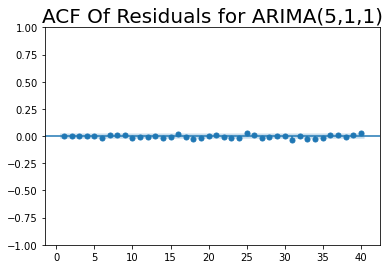

In [113]:
# Graficamos los residuos de ARIMA(5,1,1)
raw_data['residuals_ar5_i1_ma1'] = results_ar5_i1_ma1.resid
sgt.plot_acf(raw_data.residuals_ar5_i1_ma1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(5,1,1)", size=20)
plt.show()

In [114]:
# Sumario de resultados de ARIMA(5,1,1)
results_ar5_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6709
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -36759.001
Date:                Sun, 02 Oct 2022   AIC                          73532.002
Time:                        17:44:42   BIC                          73579.679
Sample:                    01-11-1994   HQIC                         73548.466
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3448      0.162      2.125      0.034       0.027       0.663
ar.L2         -0.0420      0.009     -4.589      0.000      -0.060      -0.024
ar.L3         -0.0347      0.011     -3.049      0.002      -0.057      -0.012
ar.L4          0.0229      0.012      1.936      0.053      -0.000       0.046
ar.L5         -0.0436      0.008     -5.318      0.000      -0.060      -0.028
ma.L1         -0.3574      0.163     -2.198      0.028      -0.676      -0.039
sigma2      3370.3113     35.851     94.010      0.000    3300.045    3440.577
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3477.20
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.30
Prob(H) (two-sided):                  0.67   Kurtosis:                         6.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Modelos con mayores niveles de integración

¿Cómo saber si la Integrated Series es estacionaria? CORRIENDO EL DICKEY-FULLER TEST

In [115]:
# Creo manualmente una columna en el dataframe con las diferencias de periodo en periodo para la serie de FTSE (es decir, 
# una serie con el componente de integración)
raw_data['delta_prices']= raw_data.ftse.diff(1) # el 1 indica diferencias entre valores de periodo en periodo

In [116]:
# Instanciación de un ARMA(1,1). La integración ya se realizó en la celda anterior. Recordar que el primer elemento no tiene
# valor previo y por ello es necesario excluirlo en el entrenamientdel modelo
model_delta_ar1_i1_ma1 = ARIMA(raw_data.delta_prices[1:], order=(1,0,1)) 
results_delta_ar1_i1_ma1 = model_delta_ar1_i1_ma1.fit()
results_delta_ar1_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 6708
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -36768.453
Date:                Sun, 02 Oct 2022   AIC                          73544.907
Time:                        17:44:45   BIC                          73572.151
Sample:                    01-12-1994   HQIC                         73554.315
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5861      0.633      0.926      0.355      -0.655       1.827
ar.L1          0.8376      0.041     20.225      0.000       0.756       0.919
ma.L1         -0.8701      0.037    -23.319      0.000      -0.943      -0.797
sigma2      3376.7008     35.406     95.370      0.000    3307.306    3446.096
===================================================================================
Ljung-Box (L1) (Q):                   2.36   Jarque-Bera (JB):              3708.88
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.32
Prob(H) (two-sided):                  0.93   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
# Chequeamos la estacionariedad de la serie creada. Efectivamente, es estacionaria (ver estadístico de test y P-value)
sts.adfuller(raw_data.delta_prices[1:])

(-36.8142353733154,
 0.0,
 5,
 6702,
 {'1%': -3.4313260976415894,
  '5%': -2.861971353721746,
  '10%': -2.566999605957717},
 73159.36336572774)

# ARIMAX Model

In [118]:
# Instanciación de un ARIMA(1,1,1) con variable exógena
model_ar1_i1_ma1_Xspx = ARIMA(raw_data.ftse, exog = raw_data.spx, order=(1,1,1))
results_ar1_i1_ma1_Xspx = model_ar1_i1_ma1_Xspx.fit()
results_ar1_i1_ma1_Xspx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6709
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -35704.814
Date:                Sun, 02 Oct 2022   AIC                          71417.627
Time:                        17:44:48   BIC                          71444.871
Sample:                    01-11-1994   HQIC                         71427.035
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.1840      0.026     85.219      0.000       2.134       2.234
ar.L1          0.2824      0.032      8.857      0.000       0.220       0.345
ma.L1         -0.5031      0.029    -17.521      0.000      -0.559      -0.447
sigma2      2459.0033     25.010     98.320      0.000    2409.984    2508.023
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              4413.23
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.41
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El P-value y el coeficiente de la variable exógena se interpretan de la misma manera que el resto.

# SARIMAX Models

In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [120]:
# Instanciamos el modelo con todos sus componentes
model_sarimax = SARIMAX(raw_data.ftse, exog = raw_data.spx, order=(1,0,1), seasonal_order = (2,0,1,5))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              ftse   No. Observations:                 6709
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -35723.874
Date:                           Sun, 02 Oct 2022   AIC                          71461.747
Time:                                   17:45:05   BIC                          71509.426
Sample:                               01-11-1994   HQIC                         71478.212
                                    - 09-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.1813      0.026     84.630      0.000       2.131       2.232
ar.L1          0.9997      0.000   2535.889      0.000       0.999       1.001
ma.L1         -0.2322      0.008    -27.540      0.000      -0.249      -0.216
ar.S.L5        0.9679      0.008    125.807      0.000       0.953       0.983
ar.S.L10       0.0319      0.007      4.266      0.000       0.017       0.047
ma.S.L5       -0.9990      0.003   -344.205      0.000      -1.005      -0.993
sigma2      2475.9970     25.823     95.882      0.000    2425.384    2526.610
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):              4346.55
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARCH Models

In [121]:
# Creamos la serie de retornos elevados al cuadrado
raw_data['sq_returns'] = raw_data.returns.mul(raw_data.returns) # Multiplico los elementos de la serie por sí mismos

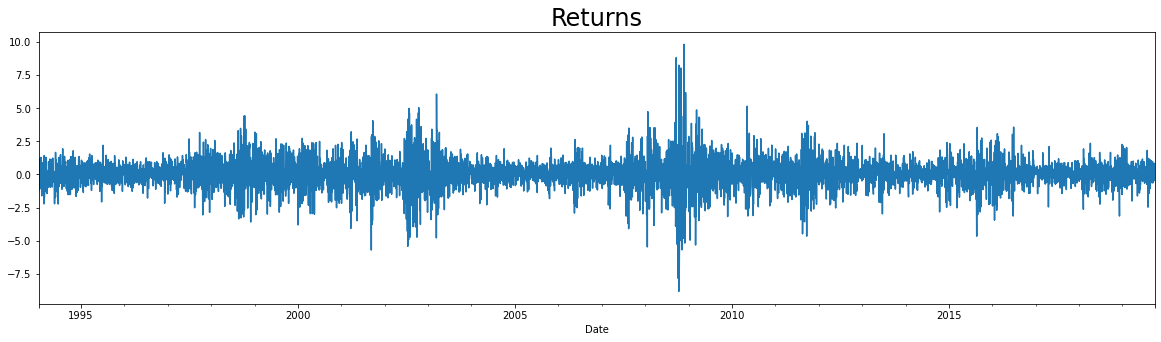

In [122]:
# Graficamos la serie de retornos VS retornos cuadráticos
raw_data.returns.plot(figsize=(20,5))
plt.title("Returns", size = 24)
plt.show()

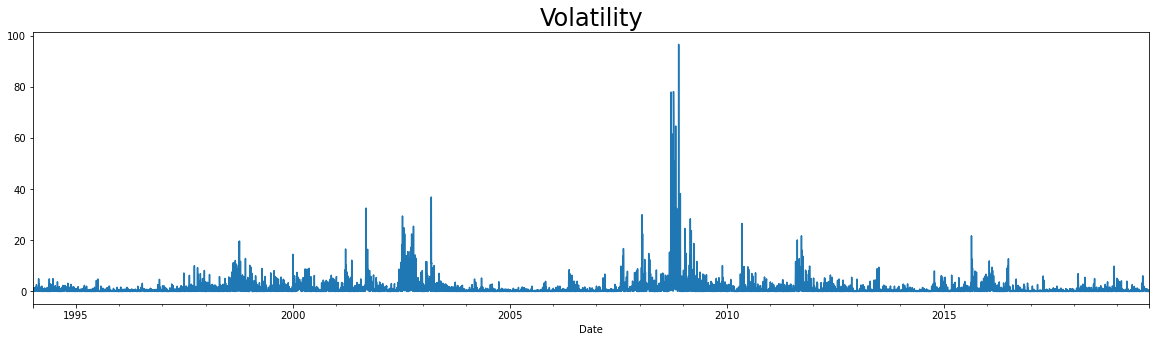

In [123]:
raw_data.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size = 24)
plt.show()

En este gráfico se muestran los periodos de menor y mayor volatilidad

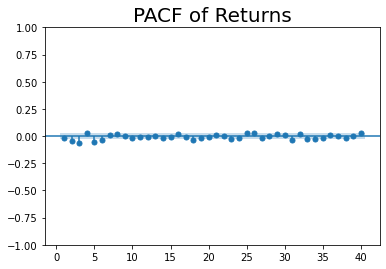

In [124]:
# PACF de los returns
sgt.plot_pacf(raw_data.returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.show()

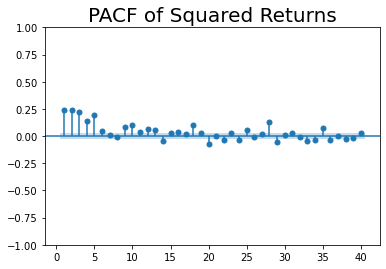

In [125]:
# PACF de la volatilidad/retornos cuadráticos
sgt.plot_pacf(raw_data.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.show()

Los coeficientes de los primeros lags son significativos, con lo cual se puede concluir que hay una trend de varianza en el corto plazo que hay que modelar.

## ARCH(1)

In [126]:
# Instanciamos el modelo con los parámetros por defecto y lo entrenamos
from arch import arch_model
model_arch1 = arch_model(raw_data.returns[1:])
results_arch1 = model_arch1.fit()
results_arch1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12329906607.89824
Iteration:      2,   Func. Count:     15,   Neg. LLF: 284572117.22538495
Iteration:      3,   Func. Count:     23,   Neg. LLF: 8971.094157255196
Iteration:      4,   Func. Count:     29,   Neg. LLF: 9026.819368532984
Iteration:      5,   Func. Count:     35,   Neg. LLF: 8983.325123682298
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8921.203492974995
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8976.001009512322
Iteration:      8,   Func. Count:     54,   Neg. LLF: 8910.798814509648
Iteration:      9,   Func. Count:     60,   Neg. LLF: 8909.001557609681
Iteration:     10,   Func. Count:     65,   Neg. LLF: 8909.001439312156
Iteration:     11,   Func. Count:     69,   Neg. LLF: 8909.001439312473
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8909.001439312156
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8909.00
Distribution:                  Normal   AIC:                           17826.0
Method:            Maximum Likelihood   BIC:                           17853.2
                                        No. Observations:                 6708
Date:                Sun, Oct 02 2022   Df Residuals:                     6707
Time:                        17:45:08   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0408  9.938e-03      4.101  4.116e-05 [2.128e-02,6.023e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0139  3.413e-03      4.064  4.823e-05 [7.181e-03,2.056e-02]
alpha[1]       0.0903  1.155e-02      7.816  5.464e-15   [6.763e-02,  0.113]
beta[1]        0.8976  1.318e-02     68.109      0.000     [  0.872,  0.923]
============================================================================

Covariance estimator: robust
"""

* GARCH MODELS RESULTS
* -"Mean Model" refiere a la media, que en este caso es constante
* -"Distribution" es la distribución de los residuos, en este caso normal
* -"Method" es el método para encontrar los coeficientes
* -"DF Model" es el número de grados de libertad del modelo, en este caso 1. Muestra el número de coeficientes que estamos intentando estimar

* MEAN MODEL
* -"mu" es el coeficiente de la constante. Su significancia se mide si tiene un "t" grande

* VOLATILITY MODEL
* -"omega" es el valor de la constante
* -"alpha[1]" es el coeficiente de los valores cuadráticos
* -"beta[1]" es el coeficiente de la varianza condicional

Las iteraciones del modelo se frenan cuando el log likelihood comienza a decrecer, sin necesidad de pasar argumentos (es decir, tiene una parada automática).

In [127]:
# Instanciación del modelo
model_arch1 = arch_model(raw_data.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch1 = model_arch1.fit(update_freq = 5) # Con este parámetro elijo la frecuencia de iteraciones para el summary
results_arch1.summary()

# El argumento "mean" refiere a la ecuación del Mean Model, la cual es invariable con el tiempo. Puede ser "Constant", "Zero", "AR" (incluir en este el argumento lags = [2, 4, 6] por ejemplo)
# El argumento "vol" refiere a la ecuación del Volatility Model, por eso "ARCH"
# El argumento "p" refiere al order o lags (sería "q")

Iteration:      5,   Func. Count:     30,   Neg. LLF: 9753.417810408042
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9753.417810408042
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9753.42
Distribution:                  Normal   AIC:                           19512.8
Method:            Maximum Likelihood   BIC:                           19533.3
                                        No. Observations:                 6708
Date:                Sun, Oct 02 2022   Df Residuals:                     6707
Time:                        17:45:09   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0342  1.298e-02      2.636  8.379e-03 [8.779e-03,5.966e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7891  3.225e-02     24.469 3.161e-132 [  0.726,  0.852]
alpha[1]       0.3811  4.393e-02      8.675  4.152e-18 [  0.295,  0.467]
========================================================================

Covariance estimator: robust
"""

* R2 y R2 Ajustado tienden a 0 debido a que la ecuación del Mean Model no es la que explica la variabilidad. Por ello no sirve como medida para los ARCH Models.

* Se toma nuevamente el Log Likelihood como medida de bondad de ajuste del modelo (cuanto más grande, mejor)

* Generalmente, si el P-value tiene un número más bajo que el e-02, es significativamente distinto a 0 (ver notación de números). Si el P-value es mayor a 0.05 (5% de nivel de confianza) entonces el coeficiente estimado no es significativamente distinto a 0, y viceversa.

* El coeficiente "Mu", al representar la constante de la ecuación del Mean Model, sirve como baseline para determinar los residuos de la ecuación del Volatility Model o varianza

## Higher-Lag ARCH Models

In [128]:
# Instanciamos un modelo que incluye 2 residuos cuadráticos pasados (p=2)
model_arch2 = arch_model(raw_data.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch2 = model_arch2.fit()
results_arch2.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 48203.76030056886
Iteration:      2,   Func. Count:     16,   Neg. LLF: 15277.827843156298
Iteration:      3,   Func. Count:     25,   Neg. LLF: 10106.212630469248
Iteration:      4,   Func. Count:     32,   Neg. LLF: 9754.711175459572
Iteration:      5,   Func. Count:     39,   Neg. LLF: 9492.90584432141
Iteration:      6,   Func. Count:     44,   Neg. LLF: 9492.90547414716
Iteration:      7,   Func. Count:     48,   Neg. LLF: 9492.905474147236
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9492.90547414716
            Iterations: 7
            Function evaluations: 48
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9492.91
Distribution:                  Normal   AIC:                           18993.8
Method:            Maximum Likelihood   BIC:                           19021.1
                                        No. Observations:                 6708
Date:                Sun, Oct 02 2022   Df Residuals:                     6707
Time:                        17:45:09   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0414  1.130e-02      3.665  2.473e-04 [1.927e-02,6.356e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6069  2.733e-02     22.205 3.042e-109 [  0.553,  0.660]
alpha[1]       0.2403  3.122e-02      7.698  1.387e-14 [  0.179,  0.302]
alpha[2]       0.2608  3.068e-02      8.501  1.875e-17 [  0.201,  0.321]
========================================================================

Covariance estimator: robust
"""

* Se incrementó el valor del Log Likelihood, así como el AIC/BIC descendió. Los coeficientes también son significativos.

* Se deja de probar incrementar los lags cuando las medidas no muestran mejoras o bien los coeficientes no son significativos.

# GARCH Models

## GARCH(1,1)

In [129]:
# Instanciamos un simple GARCH model para medir la volatilidad de los retornos
model_garch11 = arch_model(raw_data.returns[1:], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch11 = model_garch11.fit(update_freq = 5)
results_garch11.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 8983.325123682298
Iteration:     10,   Func. Count:     65,   Neg. LLF: 8909.001439312156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8909.001439312156
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8909.00
Distribution:                  Normal   AIC:                           17826.0
Method:            Maximum Likelihood   BIC:                           17853.2
                                        No. Observations:                 6708
Date:                Sun, Oct 02 2022   Df Residuals:                     6707
Time:                        17:45:09   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0408  9.938e-03      4.101  4.116e-05 [2.128e-02,6.023e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0139  3.413e-03      4.064  4.823e-05 [7.181e-03,2.056e-02]
alpha[1]       0.0903  1.155e-02      7.816  5.464e-15   [6.763e-02,  0.113]
beta[1]        0.8976  1.318e-02     68.109      0.000     [  0.872,  0.923]
============================================================================

Covariance estimator: robust
"""

## Higher-Lag GARCH Models

In [130]:
model_garch_12 = arch_model(raw_data.returns[1:], mean = "Constant",  vol = "GARCH", p = 1, q = 2)
results_garch_12 = model_garch_12.fit(update_freq = 5)
results_garch_12.summary()

Iteration:      5,   Func. Count:     40,   Neg. LLF: 8934.853266772625
Iteration:     10,   Func. Count:     74,   Neg. LLF: 8909.044918460602
Iteration:     15,   Func. Count:    103,   Neg. LLF: 8909.001438972558
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8909.001438918463
            Iterations: 15
            Function evaluations: 103
            Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8909.00
Distribution:                  Normal   AIC:                           17828.0
Method:            Maximum Likelihood   BIC:                           17862.1
                                        No. Observations:                 6708
Date:                Sun, Oct 02 2022   Df Residuals:                     6707
Time:                        17:45:09   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0408  9.938e-03      4.101  4.116e-05 [2.128e-02,6.023e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0139  3.320e-03      4.177  2.949e-05 [7.361e-03,2.037e-02]
alpha[1]       0.0903  1.459e-02      6.186  6.175e-10   [6.166e-02,  0.119]
beta[1]        0.8976      0.209      4.301  1.700e-05     [  0.489,  1.307]
beta[2]    1.5613e-17      0.198  7.882e-17      1.000     [ -0.388,  0.388]
============================================================================

Covariance estimator: robust
"""

* Beta[2] tiene un P-value de 1 (100%, no significativo), lo que significa que existe multicolinealidad perfecta con el Beta[2] debido a la relación que hay entre varianzas condicionales.

* Probar modificando p,q orders

# AUTOARIMA

In [131]:
from pmdarima.arima import auto_arima

In [132]:
# Generamos las series de retornos de los restantes índices
raw_data['returns_spx'] = raw_data.spx.pct_change(1)*100
raw_data['returns_dax'] = raw_data.dax.pct_change(1)*100
raw_data['returns_nikkei'] = raw_data.nikkei.pct_change(1)*100

In [133]:
# Instanciamos un modelo auto_arima con los parámetros por defecto
model_auto = auto_arima(raw_data.returns[1:])
model_auto

ARIMA(order=(4, 0, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Del argumento order se desprende que es un ARMA(4,5)

In [134]:
# Imprimimos el sumario de entrenamiento
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6708
Model:               SARIMAX(4, 0, 5)   Log Likelihood              -10099.065
Date:                Sun, 02 Oct 2022   AIC                          20218.130
Time:                        17:49:18   BIC                          20286.240
Sample:                    01-12-1994   HQIC                         20241.650
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0935      0.079      1.190      0.234      -0.061       0.248
ar.L2         -0.6010      0.079     -7.641      0.000      -0.755      -0.447
ar.L3         -0.1124      0.072     -1.555      0.120      -0.254       0.029
ar.L4          0.2648      0.075      3.537      0.000       0.118       0.411
ma.L1         -0.1130      0.078     -1.440      0.150      -0.267       0.041
ma.L2          0.5580      0.080      6.969      0.000       0.401       0.715
ma.L3          0.0373      0.071      0.526      0.599      -0.102       0.176
ma.L4         -0.2626      0.075     -3.523      0.000      -0.409      -0.117
ma.L5         -0.0866      0.008    -10.829      0.000      -0.102      -0.071
sigma2         1.1898      0.011    108.341      0.000       1.168       1.211
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              9643.44
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
# Argumentos del modelo auto_arima
model_auto = auto_arima(raw_data.returns[1:], exogenous = raw_data[['returns_spx', 'returns_dax', 'returns_nikkei']][1:], 
                        m = 5, max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                        maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                        out_of_sample = int(len(raw_data)*0.2))

# exogenous -> outside factors (e.g other time series)
# m -> seasonal cycle length (la distancia entre las observaciones estacionales. Hay que saber la frecuencia de la data)
# max_order -> maximum amount of variables to be used in the regression (p + q). Puede ser un n° entero o "None"
# max_p -> maximum AR components
# max_q -> maximum MA components. Seteando individualmente p y q pruebo distintas combinaciones
# max_d -> maximum Integrations
# max_P, max_Q, max_D -> Seasonal orders. Por default, están seteados en 2, 2, 1
# maxiter -> maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)
# alpha -> level of significance, default is 5%, which we should be using most of the time
# n_jobs -> how many models to fit at a time (-1 indicates "as many as possible")
# trend -> "ct" usually (significa constant and trend). Implica una relación lineal de los values y la
# information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
#        (Akaike Information Criterion, Corrected Akaike Information Criterion,
#        Bayesian Information Criterion, Hannan-Quinn Information Criterion, or
#        "out of bag"--for validation scoring--respectively)
# out_of_smaple -> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size). Ello cuando el OOB es el information_criterion

La/s serie/s endógena y exógena/s deben tener el mismo tipo de datos (returns - returns, precios - precios, etc.). No se debe mezclar data estacionaria con data No-estacionaria.

In [136]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 6708
Model:             SARIMAX(0, 0, 4)x(0, 0, [1], 5)   Log Likelihood              -10107.552
Date:                             Sun, 02 Oct 2022   AIC                          20231.104
Time:                                     17:59:27   BIC                          20285.592
Sample:                                 01-12-1994   HQIC                         20249.920
                                      - 09-27-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0275      0.026      1.054      0.292      -0.024       0.079
drift      -3.109e-06   7.14e-06     -0.436      0.663   -1.71e-05    1.09e-05
ma.L1         -0.0205      0.008     -2.645      0.008      -0.036      -0.005
ma.L2         -0.0472      0.007     -6.853      0.000      -0.061      -0.034
ma.L3         -0.0657      0.007     -9.556      0.000      -0.079      -0.052
ma.L4          0.0306      0.007      4.203      0.000       0.016       0.045
ma.S.L5       -0.0509      0.007     -7.487      0.000      -0.064      -0.038
sigma2         1.1969      0.011    108.439      0.000       1.175       1.219
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9730.78
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* El modelo seleccionado contiene 4 MA orders no estacionales y 1 seasonal lag MA (ma.S.L5).

* El drift coefficient representa el coeficiente de la trend lineal, y el intercepto la constante del modelo.

# Forecasting

In [137]:
# Instanciamos y entrenamos un modelo AR para la serie de precios del índice SPX
model_ar = ARIMA(df.spx, order = (1,0,0))
results_ar = model_ar.fit()

* Se debe especificar el intervalo de tiempo a predecir

* Se busca el primer día después del training set para ello

* Recordar hacer el split de la serie en train y test

* df_train = df.iloc[:size] # desde el principio de la serie hasta el punto de corte definido en la variable size
* df_test = df.iloc[size:] # desde el cutoff point hasta el final de la serie original

In [138]:
# El último día del df_train es el 05/04/2013
df_train.tail()

,spx
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [139]:
# El primer día después del training set es el 08/04/2013, mientras que el último día del testing set es el 29/01/2018
df_test

,spx
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623
...,...
2018-01-23,2839.130362
2018-01-24,2837.544008
2018-01-25,2839.253031


In [140]:
# Creamos variables que almacenan el start_date (el primer día después del último día del training set) y el end_date (el 
# cual puede ser hasta el final del testing set o a discreción -sólo que no voy a tener actuals para comparar-) 
# Ambos deben ser business days (porque en este caso así estaban seteados los intervalos de tiempo)
start_date = "2013-04-08"
end_date = "2021-01-29"

In [141]:
# Realizamos las predicciones
df_predicted = results_ar.predict(start = start_date, end = end_date)

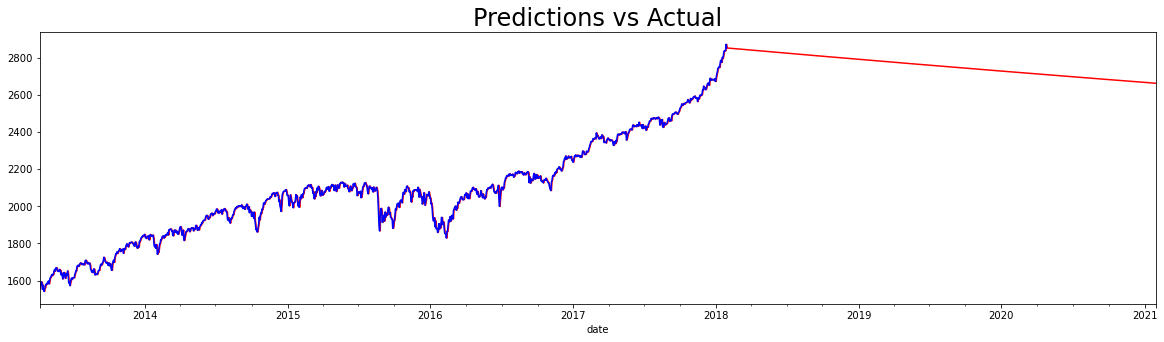

In [142]:
# Graficamos los actuals junto con el predicted
df_predicted[start_date:end_date].plot(figsize = (20,5), color = "red") # Rojo para predicted, Azul para actuals
df_test.spx[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

La curva roja que decrece de manera constante indica que los modelos AR no son buenos para predecir data no estacionaria.

In [143]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6277
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -25274.921
Date:                Sun, 02 Oct 2022   AIC                          50555.842
Time:                        17:59:31   BIC                          50576.076
Sample:                    01-07-1994   HQIC                         50562.853
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1288.7920    571.801      2.254      0.024     168.082    2409.502
ar.L1          0.9998      0.000   2594.909      0.000       0.999       1.001
sigma2       183.8184      1.747    105.217      0.000     180.394     187.243
===================================================================================
Ljung-Box (L1) (Q):                  20.16   Jarque-Bera (JB):              7028.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecasting de ARMA utilizando los Returns

### Split del raw_data Dataframe

In [145]:
# Defino el size o "cutoff point" del training set (multiplico por 0.8 para quedarme con el 80% como train set)
size_rawdata = int(len(raw_data)*0.8)

# Defino el training set y el test set
rawdata_train = raw_data.iloc[:size_rawdata] # desde el principio de la serie hasta el punto de corte definido en la variable size_rawdata
rawdata_test = raw_data.iloc[size_rawdata:] # desde el cutoff point hasta el final

In [146]:
# Trabajamos con los retornos de la serie de FTSE (raw_data.returns). Los retornos son series estacionarias.
# Imprimimos el train y test set
rawdata_train.returns.tail()

Date
2014-07-31   -0.639262
2014-08-01   -0.756302
2014-08-04   -0.025455
2014-08-05    0.074878
2014-08-06   -0.692852
Freq: B, Name: returns, dtype: float64

In [147]:
rawdata_test.returns

Date
2014-08-07   -0.584676
2014-08-08   -0.454725
2014-08-11    0.995826
2014-08-12   -0.006029
2014-08-13    0.366388
                ...   
2019-09-23   -0.255957
2019-09-24   -0.473652
2019-09-25   -0.019199
2019-09-26    0.838136
2019-09-27    0.000000
Freq: B, Name: returns, Length: 1342, dtype: float64

In [148]:
start_date = "2014-08-07"
end_date = "2019-09-27"

### AR con 5 orders - forecasting

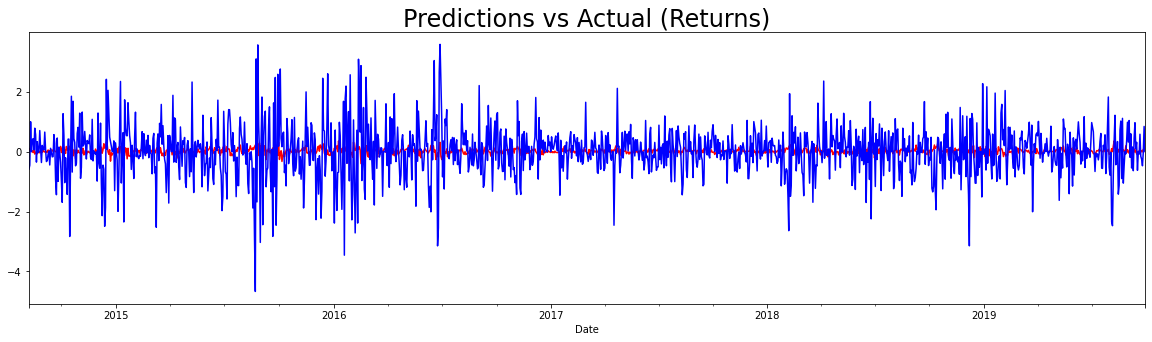

In [149]:
# Instanciación y entrenamiento del modelo
model_returns_ar = ARIMA(raw_data.returns[1:], order = (5,0,0))
results_returns_ar = model_returns_ar.fit()

# Hacemos las predicciones
rawdata_pred_ar = results_returns_ar.predict(start = start_date, end = end_date) 

# Graficamos
rawdata_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
rawdata_test.returns[start_date:end_date].plot(figsize = (20,5), color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

La línea roja pareciera ser ubicarse siempre en torno al 0, con lo cual el modelo no es bueno prediciendo. 

In [150]:
results_returns_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6708
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -10107.918
Date:                Sun, 02 Oct 2022   AIC                          20229.837
Time:                        18:06:18   BIC                          20277.514
Sample:                    01-12-1994   HQIC                         20246.301
                         - 09-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0175      0.012      1.443      0.149      -0.006       0.041
ar.L1         -0.0183      0.008     -2.403      0.016      -0.033      -0.003
ar.L2         -0.0500      0.007     -7.379      0.000      -0.063      -0.037
ar.L3         -0.0661      0.007     -9.736      0.000      -0.079      -0.053
ar.L4          0.0270      0.007      3.848      0.000       0.013       0.041
ar.L5         -0.0565      0.007     -8.313      0.000      -0.070      -0.043
sigma2         1.1922      0.011    109.377      0.000       1.171       1.214
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              9737.98
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### MA con 1 order - forecasting

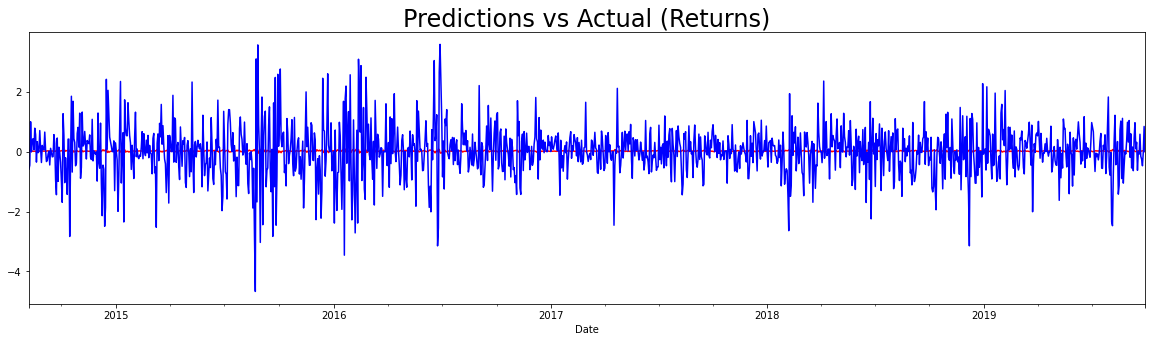

In [151]:
model_returns_ma = ARIMA(raw_data.returns[1:], order=(0,0,1))
results_returns_ma = model_returns_ma.fit()

rawdata_pred_ma = results_returns_ma.predict(start = start_date, end = end_date) 

rawdata_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
rawdata_test.returns[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [152]:
# Podemos chequear que los valores predichos son constantemente cercanos a 0 imprimiendo las predicciones
rawdata_pred_ma.head()

Date
2014-08-07    0.031504
2014-08-08    0.029662
2014-08-11    0.027052
2014-08-12   -0.001720
2014-08-13    0.017547
Freq: B, Name: predicted_mean, dtype: float64

### ARMA forecasting

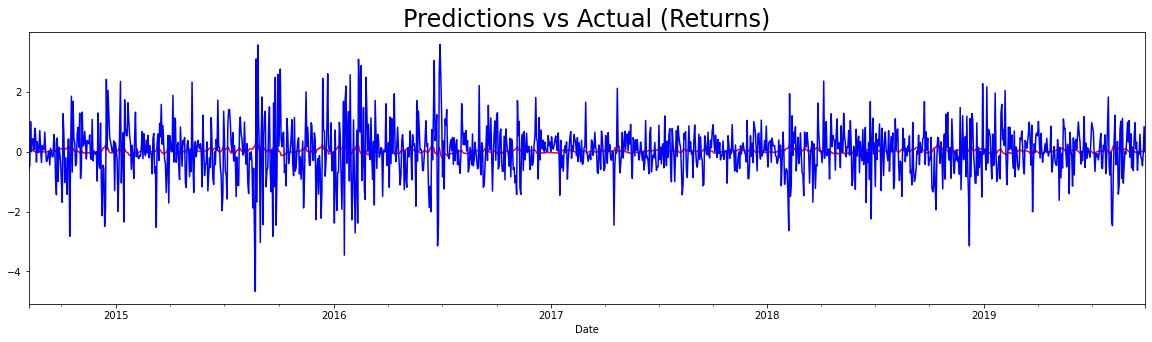

In [153]:
model_returns_arma = ARIMA(raw_data.returns[1:], order=(1,0,1))
results_returns_arma = model_returns_arma.fit()

rawdata_pred_arma = results_returns_arma.predict(start = start_date, end = end_date)

rawdata_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
rawdata_test.returns[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### ARMAX forecasting

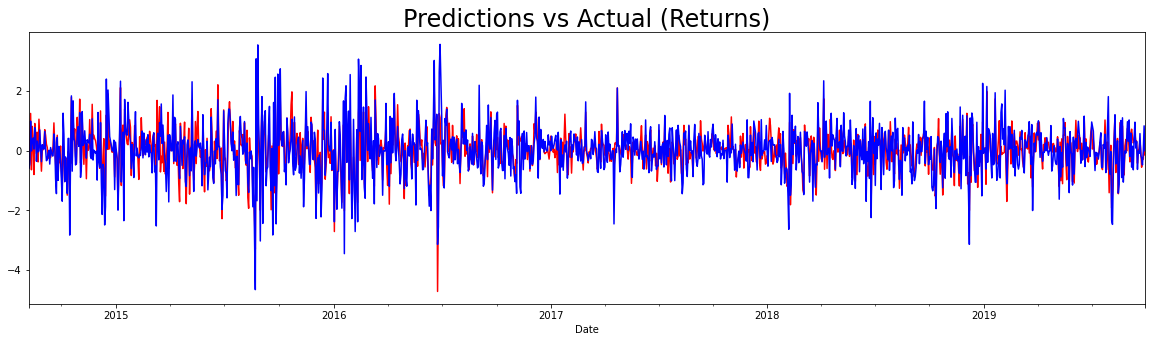

In [154]:
model_returns_armax = ARIMA(raw_data.returns[1:], exog = raw_data[["returns_spx","returns_dax","returns_nikkei"]][1:], order = (1,0,1))
results_returns_armax = model_returns_armax.fit()

# Cuando realizamos las predicciones las variables exógenas deben provenir del test set
# En este caso no se necesita eliminar el primer elemento de la serie, ya que existe un valor previo
rawdata_pred_armax = results_returns_armax.predict(start = start_date, end = end_date, 
                                          exog = rawdata_test[["returns_spx","returns_dax","returns_nikkei"]][start_date:end_date]) 

rawdata_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
rawdata_test.returns[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

Las predicciones del ARIMAX Model se aproximan más a los actuals que en los modelos previos (para hacer zoom en el gráfico, plotear por ejemplo un año). Esto es muy útil para realizar análisis

Lo que no se puede realizar con este modelo es forecasting, porque no hay actuals contra los cuales comparar la precisión de las estimaciones.

Si voy a utilizar el componente Integrado del ARIMA, se debe trabajar con series no estacionarias/de precios. Las predicciones, entonces, saldrán de una nueva serie de precios integrados (la cual se debe splitear en train/test).

### SARMA forecasting

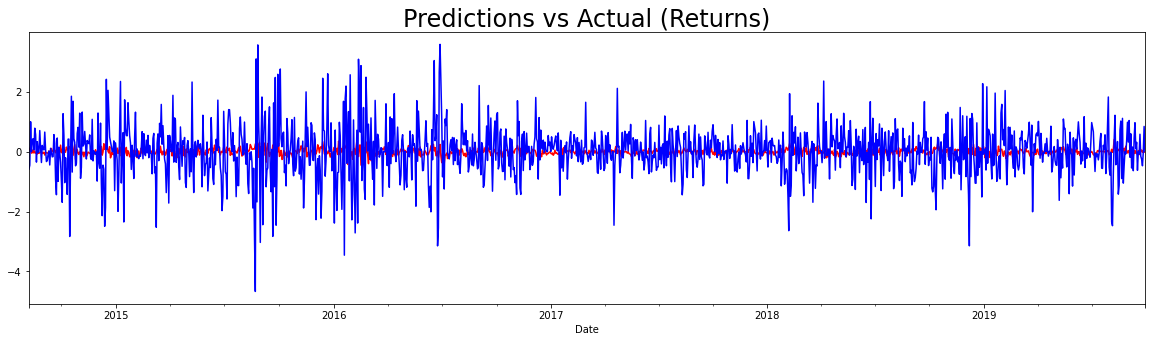

In [155]:
model_returns_sarma = SARIMAX(raw_data.returns[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_returns_sarma = model_returns_sarma.fit()

rawdata_pred_sarma = results_returns_sarma.predict(start = start_date, end = end_date) 

rawdata_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
rawdata_test.returns[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARIMAX forecasting

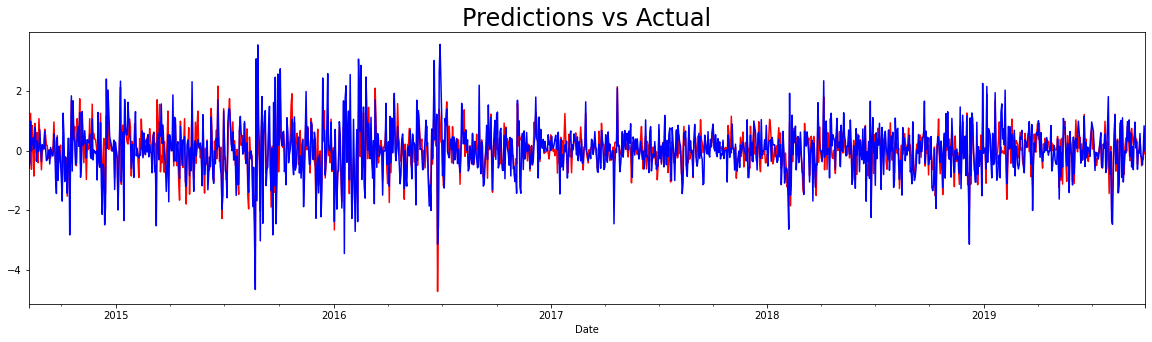

In [156]:
model_returns_sarimax = SARIMAX(raw_data.returns[1:], exog = raw_data[["returns_spx","returns_dax","returns_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_returns_sarimax = model_returns_sarimax.fit()

rawdata_pred_sarimax = results_returns_sarimax.predict(start = start_date, end = end_date, 
                                              exog = rawdata_test[["returns_spx","returns_dax","returns_nikkei"]][start_date:end_date]) 

rawdata_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
rawdata_test.returns[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA forecasting

In [157]:
# Instanciamos el modelo con variables exógenas y los argumentos estacionales y no estacionales
model_auto = auto_arima(raw_data.returns[1:], exogenous = raw_data[['returns_spx', 'returns_dax', 'returns_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

La instanciación del modelo es muy costosa en tiempo y recursos computacionales.

In [158]:
# Convertimos el numpy array que devuelve la predicción del modelo en un Pandas dataframe
rawdata_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(rawdata_test[start_date:end_date]), # Predecimos todos los valores del conjunto de test
                            exogenous = rawdata_test[['returns_spx', 'returns_dax', 'returns_nikkei']][start_date:end_date]),
                            index = rawdata_test[start_date:end_date].index)

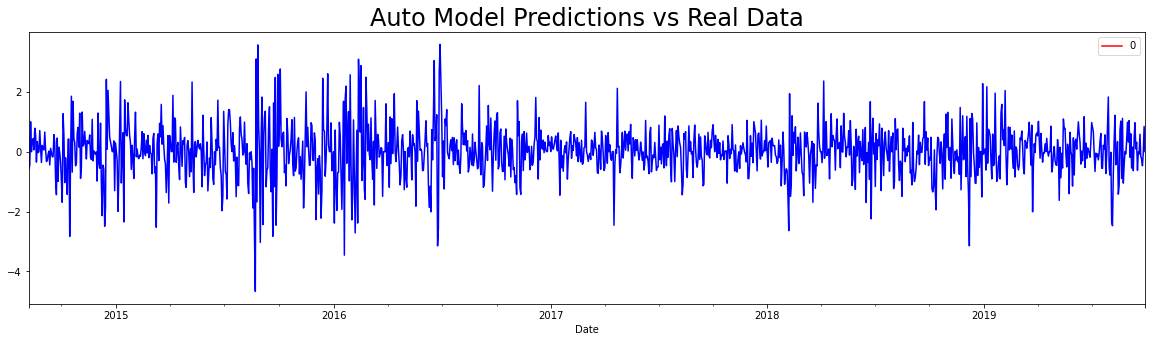

In [159]:
# Graficamos
rawdata_auto_pred.plot(figsize = (20,5), color = "red")
rawdata_test.returns[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparando los resultados de los modelos para los Returns

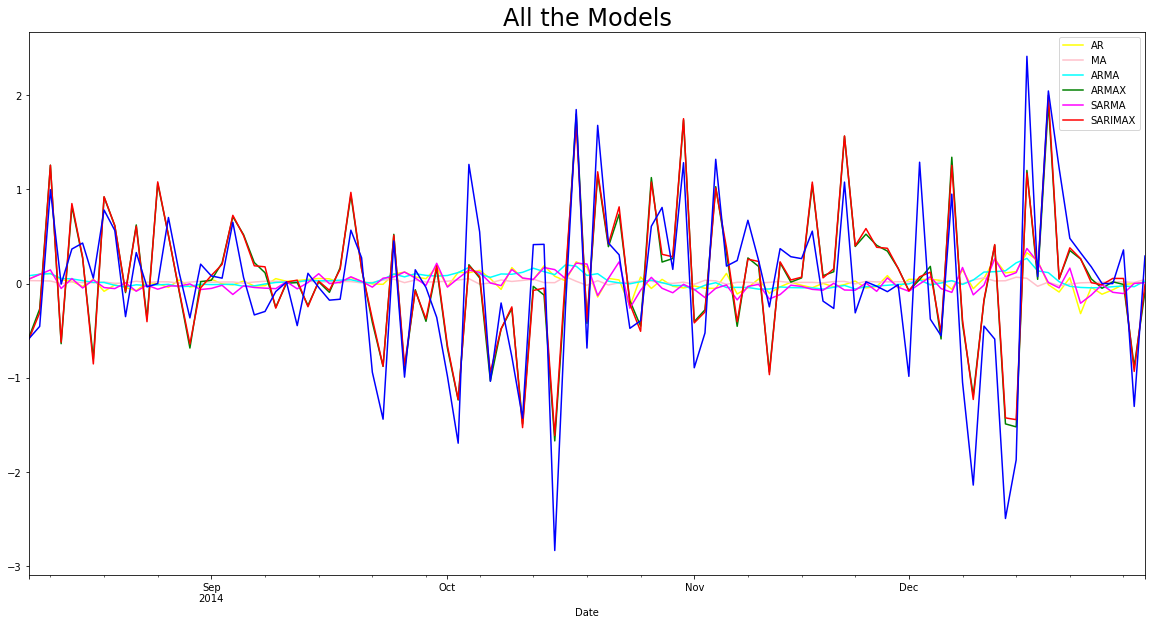

In [160]:
end_date = "2014-12-31" # Ajusto la fecha para poder observar con mejor detalle la bondad de ajuste de c/modelo a los actuals
rawdata_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
rawdata_pred_ma[start_date:end_date].plot(color = "pink")
rawdata_pred_arma[start_date:end_date].plot(color = "cyan")
rawdata_pred_armax[start_date:end_date].plot(color = "green")
rawdata_pred_sarma[start_date:end_date].plot(color = "magenta")
rawdata_pred_sarimax[start_date:end_date].plot(color = "red")
rawdata_test.returns[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

SARIMAX es el modelo que mejor se aproxima a los actuals.

## Volatility forecasting

In [161]:
# Instanciación del modelo
model_garch = arch_model(raw_data.returns[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
results_garch = model_garch.fit(last_obs = start_date, update_freq = 10)

# last_obs es la última observación. Seteándola en el start_date sólo incluye el training set
# update_freq es la frecuencia de impresión de las iteraciones del modelo

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7323.33994686631
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7323.33993387901
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


In [162]:
# Realizamos las predicciones
pred_garch = results_garch.forecast(horizon = 1, align = 'target')

# horizon es la cantidad de observaciones que se quiere que el modelo prediga para cada fecha
# align determina si matchea el valor con la fecha en que es hecha la predicción

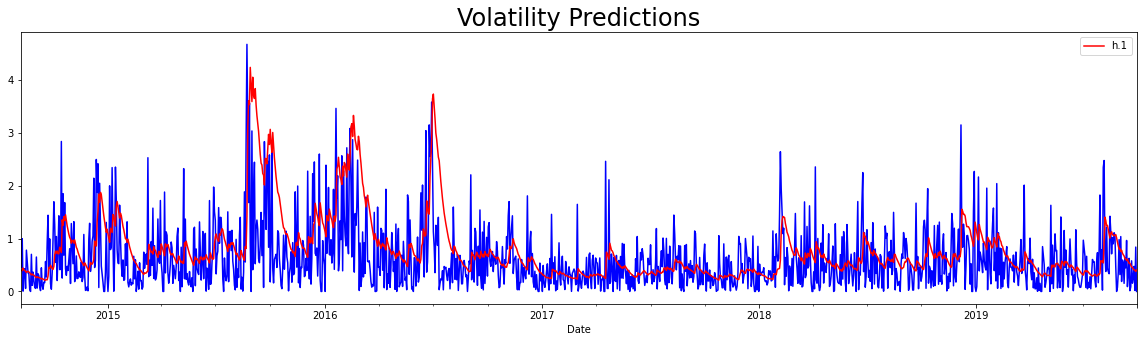

In [163]:
# Graficamos
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
rawdata_test.returns.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

# residual_variance es el atributo (la varianza condicional) del DF que contiene las predicciones
# .abs() devuelve el valor absoluto 
# zorder (z order) sirve para decidir la línea de cual serie se plotea arriba de la otra

El modelo predice bien los periodos de shock y periodos consecutivos de alta/baja volatilidad.

In [164]:
# Con el argumento horizon seteado en 100, el modelo realiza forecasting a 100 días futuros luego de finalizado el testing
# set
pred_garch = results_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:] # -1 significa que comienza desde el último día del testing set

# 001, 002, etc. son los días forecasteados

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-27,0.405091,0.384394,0.416568,0.427724,0.454561,0.487247,0.501012,0.538111,0.578807,0.585239,...,0.949532,0.881458,0.899922,0.917833,0.9253,0.945863,0.945609,0.945641,0.921554,0.925934
